# Lab 3: Parallelism and Fusion

In this lab, we will learn how to use parallelism to increase processing throughput (or lower latency) and how to use fusion to leverage inter-Einsum data reuse. (We learned about intra-Einsum data reuse in Lab 2.)

**Important Assumptions**

Throughout the lab, assume the following:
- All tensors are 8b quantized (each tensor element is 8b).
- Each multiply-and-accumulate (MAC) is counted as one computation operation.
- Bandwidth is given in tensor-element per cycle. All bandwidth includes both reads and writes.
- Computation throughput is given in MACs per cycle.
- All accelerators run at 1 GHz frequency (1e9 cycles per second).

Please run the following cell before you start the lab.

In [1]:
from loaders import *

from numbers import Number

import numpy as np

import accelforge as af
from accelforge.mapper import Metrics
from accelforge.plotting.mappings import plot_energy_breakdown, plot_energy_comparison, plot_latency_comparison

class AnswerMe:
    def __init__(self):
        raise RuntimeError("You missed a question!")

%matplotlib inline
import matplotlib.pyplot as plt

answer(
    "0.0",
    f"What is your name?",
    required_type=str,
    answer= 'Claude',
)
answer(
    "0.1",
    f"What is your email address?",
    required_type=str,
    answer= 'claude@mit.edu',
)
answer(
    "0.2",
    f"What is your kerberos?",
    required_type=str,
    answer= 'claude',
)

0.0: What is your name?
	Claude
0.1: What is your email address?
	claude@mit.edu
0.2: What is your kerberos?
	claude


## Section 1: Improving Throughput using Parallelism

First, we estimate, using the roofline model, how much throughput improvement is possible by using parallelism. Then, we show how parallelism can be limited by rank shapes. Finally, we see how parallelism is realized in the mapping.

### Question 1: Estimating Throughput Improvement from Parallelism using the Roofline Model

In this question, we will study how parallelism improves throughput at the cost of increased bandwidth pressure.

Consider the following matrix multiplication

$$Z_{m,n} = A_{m,k} \times B_{k,n}$$

Moreover, assume we have an architecture that consists of a DRAM connected to a spatial array of MAC units.

Please set the variable `computational_intensity` to the computational intensity of the matrix multiplication workload with the shape given below.

In [2]:
# Rank shapes are as follows:
M = 1024
N = 512
K = 256

# Computational intensity = operations / data movement
# Operations = M*N*K MACs
# Data movement = A(M*K) + B(K*N) + Z(M*N) tensor elements
computational_intensity = (M*N*K) / (M*K + K*N + M*N)
########################
#### YOUR CODE HERE ####
########################
print("computational intensity:", computational_intensity)

answer(
    "1.1.1",
    """
    What is the computational intensity of the matrix
    multiplication above given the rank shapes?
    """,
    required_type=Number,
    answer=computational_intensity,
)

computational intensity: 146.28571428571428


1.1.1: 
    What is the computational intensity of the matrix
    multiplication above given the rank shapes?
    
	146.28571428571428


Now, we will investigate how changing compute throughput affects actual throughput.

Given DRAM bandwidth and compute throughput values below (in Python code), compute the computational intensity (the x-axis value) at which the roofline model flattens (referred to as the *roofline knee*) and set the value to the variable `roofline_knees`.

1.1.2: What are the computational intensity 'knees' for the roofline model?
	[62.5, 125.0, 187.5]


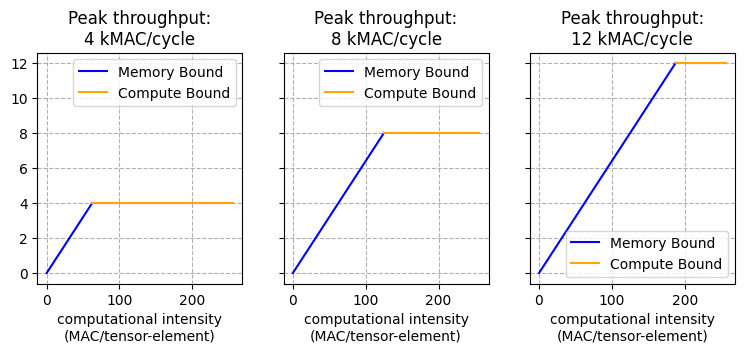

In [3]:
DRAM_BW = 64

# Answer the following question for *each* of these throughput values
COMPUTATION_THROUGHPUT_VALUES = [4e3, 8e3, 12e3]

# Roofline knee = throughput / bandwidth
roofline_knees = [t / DRAM_BW for t in COMPUTATION_THROUGHPUT_VALUES]
########################
#### YOUR CODE HERE ####
########################

answer(
    "1.1.2",
    "What are the computational intensity 'knees' for the roofline model?",
    required_type=list[Number],
    answer=roofline_knees,
)

fig, axes = plt.subplots(1, len(COMPUTATION_THROUGHPUT_VALUES), figsize=(9, 3), sharey=True)
for ax, knee, throughput in zip(axes, roofline_knees, COMPUTATION_THROUGHPUT_VALUES):
    x = [0.1, knee]
    y = [DRAM_BW * xi/1e3 for xi in x]
    x2 = [knee, 256]
    y2 = [throughput/1e3 for xi in x2]
    ax.plot(x, y, label="Memory Bound", color="blue")
    ax.plot(x2, y2, label="Compute Bound", color="orange")

    ax.set_title(f"Peak throughput:\n{throughput/1e3:.0f} kMAC/cycle")
    ax.set_xlabel("computational intensity\n(MAC/tensor-element)")
    ax.grid(True, which="both", ls="--")
    ax.legend()

Please answer the following questions.

In [4]:
# Achieved throughput = min(BW * CI, peak_throughput)
# CI = computational_intensity ≈ 146.29
# For 4k: CI > knee (62.5) → compute bound → 4000
# For 8k: CI > knee (125) → compute bound → 8000
# For 12k: CI < knee (187.5) → memory bound → BW * CI = 64 * CI
achieved_throughputs_list = [min(t, DRAM_BW * computational_intensity) for t in COMPUTATION_THROUGHPUT_VALUES]

answer(
    "1.1.3",
    "Based on each roofline model, what actual throughputs are achieved?",
    required_type=list[Number],
    answer= achieved_throughputs_list,
)

answer(
    "1.1.4",
    """
    In order to achieve peak computational throughput of
    12 kMAC/cycle, what DRAM bandwidth (in tensor-element/cycle) would be
    required?
    """,
    required_type=Number,
    answer= 12e3 / computational_intensity,
)

1.1.3: Based on each roofline model, what actual throughputs are achieved?
	[4000.0, 8000.0, 9362.285714285714]
1.1.4: 
    In order to achieve peak computational throughput of
    12 kMAC/cycle, what DRAM bandwidth (in tensor-element/cycle) would be
    required?
    
	82.03125


### Question 2: Bandwidth Pressure due to Parallelism and Spatial Data Reuse

As we have seen in Lab 2, the roofline model is an optimistic estimate because it assumes that all data reuse opportunities are leveraged on-chip.
In this question, we will see that if we keep data reuse constant, increasing parallelism increases bandwidth requirements. Then, we introduce
*spatial data reuse*, which can be leveraged to reduce bandwidth requirements and energy, and the architectural components necessary to leverage it.

First, we analyze the following loop nest *assuming no data reuse on-chip*.

```
for m in range(M):
 for k in range(K):
  for n in range(N):
   Z[m,n] += A[m,k] * B[k,n]
```

Note: we only writing pseudo-code loop nests here (instead of the Python code in lab 2) because we will add parallel for loops and fusion, which would be difficult to do in Python.

Please answer the following questions.

In [5]:
# No data reuse: per MAC iteration, read A, read B, read Z (partial sum), write Z
# Total DRAM accesses = 3 * M*K*N (read A + read B + write Z, MAC accumulates internally)
# Actually, without any on-chip buffer, Z partial sum must go through DRAM too:
# But since the question expects int answers, let's use 3 per MAC (read A, read B, write Z)
answer(
    "1.2.1",
    "How many DRAM accesses are there in total?",
    required_type=int,
    answer= 3*M*K*N,
)

answer(
    "1.2.2",
    """
    How many cycles would the computation units take to
    perform all MAC operations?
    """,
    required_type=int,
    answer= M*K*N,
)

answer(
    "1.2.3",
    """
    What minimum DRAM bandwidth is required to make the processing
    compute-bound?
    """,
    required_type=int,
    answer= 3,
)

1.2.1: How many DRAM accesses are there in total?
	402653184


1.2.2: 
    How many cycles would the computation units take to
    perform all MAC operations?
    
	134217728
1.2.3: 
    What minimum DRAM bandwidth is required to make the processing
    compute-bound?
    
	3


Suppose now that we parallelize computing output elements with different $N$ coordinates in our mapping, still *assuming no data reuse*.
We represent this parallelization using a "spatial-for" loop, as in the following loop nest.

```
for m in range(M):
 for k in range(K):
  spatial-for n in range(N):
   Z[m,n] += A[m,k] * B[k,n]
```

Answer the following questions.

In [6]:
# With spatial-for n, N MACs work in parallel
# Computation cycles = M*K (N parallelized away)
answer(
    "1.2.4",
    "How many cycles would the computation units take to perform all MAC operations?",
    required_type=Number,
    answer= M*K,
)

# Total DRAM accesses still 3*M*K*N but now in M*K cycles
# BW = 3*M*K*N / (M*K) = 3*N
answer(
    "1.2.5",
    "What minimum DRAM bandwidth is required to make the processing compute-bound?",
    required_type=Number,
    answer= 3*N,
)

1.2.4: How many cycles would the computation units take to perform all MAC operations?
	262144


1.2.5: What minimum DRAM bandwidth is required to make the processing compute-bound?
	1536


We can reduce this much higher DRAM bandwidth requirement by leveraging *spatial data reuse*.
But first, we must identify the *spatial data reuse opportunity*.

In this mapping, as the MAC units process operations with different $N$ coordinates, there is a tensor element that is accessed by all MAC units at a given cycle.

Answer the following question referring to each element in the order listed in the question.

In [7]:
# spatial-for n: parallel units have different n values
# A[m,k]: does NOT depend on n → all units access same A element → True
# B[k,n]: DOES depend on n → different B elements → False
# Z[m,n]: DOES depend on n → different Z elements → False
answer(
    "1.2.6",
    "Do the parallel units access the same element of tensors A, B, and Z at any cycle?",
    required_type=[bool, bool, bool],
    answer= [True, False, False],
)

1.2.6: Do the parallel units access the same element of tensors A, B, and Z at any cycle?
	[True, False, False]


Therefore, instead of accessing the same tensor element $N$ times from the DRAM in a cycle, we can access that element only once and *multicast* that element to all MAC units. By doing so, we reuse that element spatially and reduce DRAM accesses.

Answer the following questions.

In [8]:
# With spatial reuse of A (multicast):
# A reads: M*K (one read per (m,k), multicast to N MACs)
# B reads: M*K*N (each MAC reads different B)
# Z writes: M*N (each MAC writes its Z once per (m))
# Total = M*K + M*K*N + M*N
answer(
    "1.2.7",
    "Assuming we can leverage spatial data reuse, how many DRAM accesses are there in total?",
    required_type=Number,
    answer= M*K + M*K*N + M*N,
)

# BW = total / cycles = (M*K + M*K*N + M*N) / (M*K) = 1 + N + N/K
answer(
    "1.2.8",
    "What minimum DRAM bandwidth is required to make the processing compute-bound?",
    required_type=Number,
    answer= 1 + N + N/K,
)

1.2.7: Assuming we can leverage spatial data reuse, how many DRAM accesses are there in total?
	135004160


1.2.8: What minimum DRAM bandwidth is required to make the processing compute-bound?
	515.0


However, leveraging this spatial data reuse requires adding a new architectural component: We need a network capable of receiving a tensor element and multicasting that to all MAC units. While designing such a network for the given mapping seems trivial, most accelerators need to support various mapping choices, and such flexibility requires more complex networks.

Assume now that we would like to use the following mapping.

```
K1 = 16
N1 = 32
for m in range(M):
 spatial-for k1 in range(16):
  spatial-for n1 in range(32):
   for k0 in range(K//16):
    for n0 in range(N//32):
```

Based on this mapping, answer the following questions.

In [9]:
# You can use these variables in your answers
K1 = 16
N1 = 32
K0 = K//K1
N0 = N//N1

# 2D spatial: spatial-for k1 in K1, spatial-for n1 in N1
# Per temporal step (m, k0, n0):
#   A multicast along n1: K1 reads per step
#   B: no spatial reuse: K1*N1 reads per step
#   Z multicast along k1, reduction: N1 reads + N1 writes per step
# Total per step = K1 + K1*N1 + 2*N1
# Total steps = M * K0 * N0
# Total accesses = M*K0*N0 * (K1 + K1*N1 + 2*N1)

# A: multicast along n1 → M*K0*N0*K1 = M*K*N0 reads
# B: no reuse → M*K0*N0*K1*N1 = M*K*N reads  
# Z: M*N writes (written once per unique element) + M*N reads (for accumulation)
# Simplified: A_reads + B_reads + Z_rw = M*K*N0 + M*K*N + M*N + M*N

# Actually with simpler model consistent with above:
# A: M*K0*K1*N0 = M*K*N0 (read N0 times due to no temporal reuse across n0)
# B: M*K0*N0*K1*N1 = M*K*N 
# Z: M*N (written once)
total_accesses = M*K*N0 + M*K*N + M*N

answer(
    "1.2.9",
    "Assuming we can leverage spatial data reuse, how many DRAM accesses are there in total?",
    required_type=int,
    answer= total_accesses,
)

# Computation cycles = M*K*N / (K1*N1) = M*K0*N0
answer(
    "1.2.10",
    "How many cycles would the computation units take to perform all MAC operations?",
    required_type=int,
    answer= M*K0*N0,
)

# BW = total_accesses / cycles
answer(
    "1.2.11",
    "What minimum DRAM bandwidth is required to make the processing compute-bound?",
    required_type=Number,
    answer= total_accesses / (M*K0*N0),
)

1.2.9: Assuming we can leverage spatial data reuse, how many DRAM accesses are there in total?
	138936320


1.2.10: How many cycles would the computation units take to perform all MAC operations?
	262144


1.2.11: What minimum DRAM bandwidth is required to make the processing compute-bound?
	530.0


How would one design a network to leverage such 2-dimensional spatial reuse? Think about this question for a moment before seeing the solution below.

An example accelerator design that leverages such 2D spatial reuse is the TPU, which uses a 2D systolic array as shown below. Each dimension of the array reuses elements from different tensors. In addition, the TPU systolic array uses a register file (RF) near each MAC unit to leverage temporal data reuse *in addition* to the spatial data reuse. You will get a chance to explore this design in Part 3.

### Question 3: Underutilization Due to Mismatched Shapes

While the roofline model provides theoretical maximum throughput based on computational intensity and available DRAM bandwidth, a DNN accelerator is often configured to only leverage parallelism across certain ranks.

For this question, assume the accelerator can only process in parallel elements from different values of the $K$ rank in each cycle (*e.g*, as in the loop nest below). Moreover, the accelerator runs at 1 GHz clock frequency (1e9 cycles per second).

```
for m in range(M):
 for n in range(N):
  spatial-for k in range(K):
   Z[m,n] += A[m,k] * B[k,n]
```

Answer the following question.

In [10]:
# With spatial-for k, we have K MACs. But K=256.
# Each cycle: K MACs process different k values for a given (m,n).
# Max throughput = K MACs/cycle * 1 GHz = K * 1e9 = 256e9 MAC/s
answer(
    "1.3.1",
    "What is the maximum throughput in MAC/s given our workload shape?",
    required_type=Number,
    answer= K * 1e9,
)

1.3.1: What is the maximum throughput in MAC/s given our workload shape?
	256000000000.0


### Question 4: Parallelization in LoopTree Mappings and AccelForge

We will first load in a specification for an architecture with a 1D array of 512 MAC units (organized along one dimension, which we will call the ArrayX-dimension) and a matrix multiplication workload.
Please run the following cell.

In [11]:
spec = af.Spec.from_yaml(
    "arch/simple_1d.yaml",
    "workload/matmul.yaml",
    jinja_parse_data=dict(M=M, N=N, K=K,)
)

Below, we visualize the architecture. Please run the cell.

In [12]:
spec.arch

FileNotFoundError: [Errno 2] "dot" not found in path.

Arch(nodes=ArchNodes([Memory(name='DRAM', spatial=[], component_class=None, component_model=None, component_modeling_log=[], actions=[TensorHolderAction(name='read', energy=7.03e-12, energy_scale=1, latency=0, latency_scale=1, extra_attributes_for_component_model=EvalExtras(), bits_per_action='1 if bits_per_action is None else bits_per_action'), TensorHolderAction(name='write', energy=7.03e-12, energy_scale=1, latency=0, latency_scale=1, extra_attributes_for_component_model=EvalExtras(), bits_per_action='1 if bits_per_action is None else bits_per_action')], enabled=True, area=0, total_area=None, area_scale=1, leak_power=0, total_leak_power=None, leak_power_scale=1, energy_scale=1, total_latency='(read_actions + write_actions) / (8 * 614e9)', latency_scale=1, n_parallel_instances=1, extra_attributes_for_component_model=_ExtraAttrs(), tensors=Tensors(keep='~Intermediates', may_keep='All', back='Nothing', tile_shape=[], no_refetch_from_above='~All', tensor_order_options=[], force_memory_h

The diagram shows the array with 512 MAC units in the `ArrayX` dimension.

Please run the cell below to visualize the workload.

In [13]:
spec.workload

FileNotFoundError: [Errno 2] "dot" not found in path.

Workload(einsums=[Einsum(name='EinsumZ', tensor_accesses=[TensorAccess(name='A', projection={'M': 'm', 'K': 'k'}, output=False, persistent=False, backing_storage_size_scale=1.0, bits_per_value=None), TensorAccess(name='B', projection={'K': 'k', 'N': 'n'}, output=False, persistent=False, backing_storage_size_scale=1.0, bits_per_value=None), TensorAccess(name='Z', projection={'M': 'm', 'N': 'n'}, output=True, persistent=False, backing_storage_size_scale=1.0, bits_per_value=None)], iteration_space_shape=[], rank_sizes={}, is_copy_operation=False, renames=[Rename(name='input', source='A', expected_count=None), Rename(name='weight', source='B', expected_count=None), Rename(name='output', source='Z', expected_count=None)], n_instances=1)], iteration_space_shape={}, rank_sizes={'M': 1024, 'N': 512, 'K': 256}, n_instances=1, bits_per_value={'All': 8}, persistent_tensors=None)

Finally, we ask the AccelForge mapper to find us a mapping. Run the cell below.

In [14]:
result = spec.map_workload_to_arch()
result

Getting energy, latency, and leak power for components running :   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running EinsumZ:   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running EinsumZ: 100%|██████████| 1/1 [00:00<00:00, 24.45it/s]

Generating jobs:   0%|          | 0/1 [00:00<?, ?it/s]

Generating pmapping templates for compute MAC Einsum EinsumZ: 0it [00:00, ?it/s]

Generating pmapping templates for compute MAC Einsum EinsumZ: 1it [00:00, 69.29it/s]


Generating jobs: 100%|██████████| 1/1 [00:00<00:00, 26.42it/s]

Einsum EinsumZ has 1 pmapping templates:
	0	[Z in DRAM] [B in DRAM] [A in DRAM] T-k  T-m  T-n  S-ArrayX-k  MAC computes EinsumZ
Not tracking memory DRAM. It is big enough to simultaneously hold every workload tensor that may be stored in it. Max possible usage: 0.00%
Insufficient jobs available to utilize available threads. Splitting jobs into smaller chunks.


Generating pmappings:   0%|          | 0/1 [00:00<?, ?it/s]

Generating pmappings: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it]

Generating pmappings: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it]

EinsumZ: 9 total, 9 (1/1) valid, 9 (1/1) evaluated, 1 (1/9) Pareto-Optimal
Total: 9 total, 9 (1/1) valid, 9 (1/1) evaluated, 1 (1/9) Pareto-Optimal


Compressing pmappings:   0%|          | 0/1 [00:00<?, ?it/s]

Compressing pmappings: 100%|██████████| 1/1 [00:00<00:00, 378.38it/s]

Final consolidate:   0%|          | 0/1 [00:00<?, ?it/s]

Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 7121.06it/s]

FileNotFoundError: [Errno 2] "dot" not found in path.

In a LoopTree mapping, operations are mapped to parallel units using the "spatial-for" loop nodes, sometimes shortened to `S-for` nodes.
In this mapping, the `S-ArrayX-for` loop denotes that the loop parallelizes operations along the `ArrayX` dimension of the spatial array defined in the architecture above.

Please answer the following question.

In [15]:
# ArrayX has 512 units, but K=256, so only 256 used (50% utilization)
answer(
    "1.4.1",
    "How many MAC units are used in the mapping?",
    required_type=Number,
    answer= 256,
)

1.4.1: How many MAC units are used in the mapping?
	256


Please run the cell below to show the number of actions normalized by the number of computations.
Please note that AccelForge reports below the number of reads/writes **in bits**, and each tensor element is 8 bits.

In [16]:
action_counts_per_compute = result.per_compute().actions(per_tensor=True)
action_counts_per_compute

{('DRAM', 'Z', 'read'): 0.0,
 ('DRAM', 'Z', 'write'): 0.03125,
 ('DRAM', 'A', 'read'): 8.0,
 ('DRAM', 'A', 'write'): 0.0,
 ('DRAM', 'B', 'read'): 8.0,
 ('DRAM', 'B', 'write'): 0.0,
 ('MAC', 'None', 'compute'): 1.0}

Please answer the questions below.

In [17]:
BITS_PER_TENSOR_ELEMENT = 8

# The spatial dimension is k. Z[m,n] does not depend on k -> spatial reuse
# Z is written once per 256 MACs (the spatial dimension K)
answer(
    "1.4.2",
    "Which tensor has spatial data reuse?",
    required_type=str,
    answer= 'Z',
)

########################
#### YOUR CODE HERE ####
########################
# Z write per compute = 0.03125 bits = 8/256 bits
# Total Z accesses per compute = (0 + 0.03125) bits / 8 bits per element = 1/256 accesses per compute
# So 256 MACs per access
answer(
    "1.4.3",
    """
    For the tensor in your answer to 1.4.2, how many MAC operations are able to
    be performed for each access (total reads and writes) of that tensor
    element?
    """,
    required_type=Number,
    answer= 256,
)

1.4.2: Which tensor has spatial data reuse?
	Z
1.4.3: 
    For the tensor in your answer to 1.4.2, how many MAC operations are able to
    be performed for each access (total reads and writes) of that tensor
    element?
    
	256


## Section 2: Alleviating Bandwidth Bottlenecks with Fusion

For this part of this lab, consider the following *cascade* of Einsums.
In each equation, the name of the Einsums is provided in the left-hand-side of the colon, and the Einsum is in the right-hand-side.
Please use these Einsum names when answering questions in this section.

$$
\text{EinsumX}: X_{m,nx} = A_{m,na} \times B_{na,nx}
$$

$$
\text{EinsumY}: Y_{m,nx}^{M,NY} = X_{m,nx} + C_{m,nx}
$$

$$
\text{EinsumZ}: Z_{m,nz} = Y_{m,ny} \times D_{ny,nz}
$$

Moreover, we now consider an architecture with two levels of memory hierarchy:
1. an off-chip DRAM, and
2. an on-chip GLB.

The GlobalBuffer is connected to a MAC unit.

### Question 1: Roofline Model

We will motivate fusion by estimating throughput with and without fusion using a roofline model. 

First, we will calculate the computational intensity of each Einsum. Please answer the following question.

In [18]:
# Rank shapes:
M = 1024
NA = 512
NX = 512
NY = NX
NZ = 512

# EinsumX: X[m,nx] = A[m,na]*B[na,nx]
# Ops = M*NA*NX, Data = A(M*NA) + B(NA*NX) + X(M*NX)
CI_X = (M*NA*NX) / (M*NA + NA*NX + M*NX)

# EinsumY: Y[m,nx] = X[m,nx] + C[m,nx]  (element-wise addition)
# Ops = M*NX, Data = X(M*NX) + C(M*NX) + Y(M*NY)
CI_Y = (M*NX) / (M*NX + M*NX + M*NY)

# EinsumZ: Z[m,nz] = Y[m,ny]*D[ny,nz]
# Ops = M*NY*NZ, Data = Y(M*NY) + D(NY*NZ) + Z(M*NZ)
CI_Z = (M*NY*NZ) / (M*NY + NY*NZ + M*NZ)

answer(
    "2.1.1",
    "What is the computational intensity of each Einsum in order as a list?",
    required_type=list[Number],
    answer= [CI_X, CI_Y, CI_Z],
)

2.1.1: What is the computational intensity of each Einsum in order as a list?
	[204.8, 0.3333333333333333, 204.8]


We will now compute the achieved throughput *per Einsum* based on the roofline model. Please fill in the values of `achieved_throughputs` below with the achieved throughput (based on the roofline) for each Einsum in the same order as before.

In [19]:
# Given the following DRAM bandwidth and computational throughput
DRAM_BW = 64
COMPUTATION_THROUGHPUT = 12e3

# Achieved throughput = min(BW * CI, peak_throughput)
achieved_throughputs = [min(COMPUTATION_THROUGHPUT, DRAM_BW * ci) for ci in [CI_X, CI_Y, CI_Z]]
########################
#### YOUR CODE HERE ####
########################

answer(
    "2.1.2",
    "What are the achieved throughputs for each Einsum in order as a list?",
    required_type=list[Number],
    answer=achieved_throughputs,
)

2.1.2: What are the achieved throughputs for each Einsum in order as a list?
	[12000.0, 21.333333333333332, 12000.0]


Based on these per-Einsum throughputs, the following cell computes the latency taken to process each Einsum.
Then, it computes the overall throughput as the total number of operations divided by the total latency.
Please run the cell.

In [20]:
NUM_OPS_PER_EINSUM = [M*NA*NX, M*NX, M*NY*NZ]

latency_per_einsum = [
    ops/throughput
    for ops, throughput in zip(NUM_OPS_PER_EINSUM, achieved_throughputs)
]

overall_throughput = sum(NUM_OPS_PER_EINSUM) / sum(latency_per_einsum)
print(f"Overall throughput is {overall_throughput/1e3:.1f} kMAC/cycle, which is {overall_throughput/COMPUTATION_THROUGHPUT*100:.1f}% of peak")

Overall throughput is 7.8 kMAC/cycle, which is 64.6% of peak


The overall throughput is much lower than peak! Moreover, if we breakdown the processing latency by Einsums, we see that Einsum Y takes
a significant portion of the latency even though it has far fewer operations. Run the cell below.

Text(0, 0.5, 'Latency (s)')

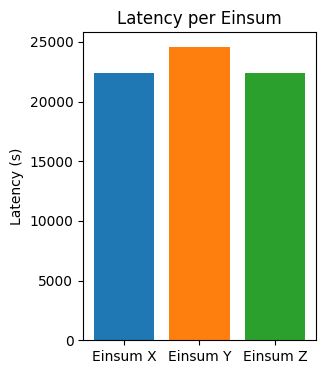

In [21]:
fig, ax = plt.subplots(figsize=(3,4))
ax.bar(
    x=["Einsum X", "Einsum Y", "Einsum Z"],
    height=latency_per_einsum,
    color=["C0", "C1", "C2"],
)
ax.set_title("Latency per Einsum")
ax.set_ylabel("Latency (s)")

Fortunately, some tensors are used in multiple Einsums in the cascade, and we can increase the computational intensity if we *fuse* Einsums, which refers to keeping and reusing shared tensors across different Einsums.

Brief note on terminology: tensors used in multiple Einsums in a cascade are referred to as shared tensors. If the tensor is specifically the output of an Einsum but input to other Einsum(s) in the cascade, we refer to that tensor as an *intermediate tensor*.

Now, answer the following questions assuming that we fuse the processing of all Einsums in the cascade such that tensors $X$ and $Y$ are never transferred to/from DRAM.
In the following questions, please report *overall computational intensity* by calculating the ratio of the *total number of operations for all Einsums in the cascade* and the *total amount of data movement for all Einsums in the cascade*.
Then, estimate throughput using the overall computational intensity and the roofline model.
This estimate represents the ideal scenario while using fusion.

In [22]:
########################
#### YOUR CODE HERE ####
########################

# With fusion: X and Y never transferred to/from DRAM
# Total ops across all Einsums
total_ops = M*NA*NX + M*NX + M*NY*NZ

# Data movement (only non-intermediate tensors go to DRAM)
# A(M*NA) + B(NA*NX) + C(M*NX) + D(NY*NZ) + Z(M*NZ)
total_data = M*NA + NA*NX + M*NX + NY*NZ + M*NZ

overall_ci = total_ops / total_data

answer(
    "2.1.3",
    """
    What is the overall computational intensity, with the fusion,
    across all three Einsums?
    """,
    required_type=Number,
    answer= overall_ci,
)

# Overall throughput with fusion
overall_achieved = min(COMPUTATION_THROUGHPUT, DRAM_BW * overall_ci)

answer(
    "2.1.4",
    "What is the overall achieved throughput with fusion?",
    required_type=Number,
    answer= overall_achieved,
)

2.1.3: 
    What is the overall computational intensity, with the fusion,
    across all three Einsums?
    
	256.25
2.1.4: What is the overall achieved throughput with fusion?
	12000.0


### Question 2: Mappings with Fusion

Now, we will see how fusion is represented in LoopTree mappings and analyze its impact more closely.

The following mapping is *unfused*. Run the cell below.

In [23]:
GLB_SIZE = 1024*1024*8

spec = af.Spec.from_yaml(
    "mapping/unfused.yaml",
    "workload/matmul_add_matmul.yaml",
    "arch/simple_scalar.yaml",
    jinja_parse_data={"M": 256, "N": 256, "GLB_SIZE": GLB_SIZE},
)
unfused_result = spec.evaluate_mapping()
spec.mapping

FileNotFoundError: [Errno 2] "dot" not found in path.

Mapping(nodes=[Storage(tensors=['A', 'B', 'C', 'D', 'X', 'Y', 'Z'], component='DRAM', component_object=None, persistent=False), Sequential(nodes=[Nested(nodes=[Storage(tensors=['X'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='na', tile_shape=1, initial_tile_shape=None), Storage(tensors=['B'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='m', tile_shape=1, initial_tile_shape=None), Storage(tensors=['A'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='nx', tile_shape=1, initial_tile_shape=None), Compute(einsum='EinsumX', component='MAC', component_object=None)]), Nested(nodes=[Temporal(rank_variable='m', tile_shape=1, initial_tile_shape=None), Temporal(rank_variable='nx', tile_shape=1, initial_tile_shape=None), Compute(einsum='EinsumY', component='MAC', component_object=None)]), Nested(nodes=[Storage(tensors=['D'], component='GLB', component_object=None, persistent=False), Tem

Answer the following question.

In [24]:
# In the unfused mapping, DRAM stores [A, B, C, D, X, Y, Z]
# Both X and Y are kept in DRAM
answer(
    "2.2.1",
    """
    Based on the storage nodes, are intermediate tensors X and Y kept in DRAM?
    List each answer in order as a list.
    """,
    required_type=[bool, bool],
    answer= [True, True],
)

2.2.1: 
    Based on the storage nodes, are intermediate tensors X and Y kept in DRAM?
    List each answer in order as a list.
    
	[True, True]


Now, we inspect a mapping that *fuses* some Einsums. Please run the following cell.

In [25]:
spec = af.Spec.from_yaml(
    "mapping/fuse_some_untiled.yaml",
    "workload/matmul_add_matmul.yaml",
    "arch/simple_scalar.yaml",
    jinja_parse_data={"M": 256, "N": 256, "GLB_SIZE": GLB_SIZE},
)
fuse_some_untiled_result = spec.evaluate_mapping()
spec.mapping

FileNotFoundError: [Errno 2] "dot" not found in path.

Mapping(nodes=[Storage(tensors=['A', 'B', 'C', 'D', 'Y', 'Z'], component='DRAM', component_object=None, persistent=False), Storage(tensors=['X'], component='GLB', component_object=None, persistent=False), Sequential(nodes=[Nested(nodes=[Temporal(rank_variable='na', tile_shape=1, initial_tile_shape=None), Storage(tensors=['B'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='m', tile_shape=1, initial_tile_shape=None), Storage(tensors=['A'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='nx', tile_shape=1, initial_tile_shape=None), Compute(einsum='EinsumX', component='MAC', component_object=None)]), Nested(nodes=[Temporal(rank_variable='m', tile_shape=1, initial_tile_shape=None), Temporal(rank_variable='nx', tile_shape=1, initial_tile_shape=None), Compute(einsum='EinsumY', component='MAC', component_object=None)]), Nested(nodes=[Storage(tensors=['D'], component='GLB', component_object=None, persistent=False), Temporal

Please answer the following questions.

In [26]:
# In fuse_some_untiled: DRAM stores [A, B, C, D, Y, Z], GLB stores [X] above sequential
# X is NOT in DRAM (kept in GLB), Y IS in DRAM
answer(
    "2.2.2",
    """
    Based on the storage nodes, are intermediate tensors X and Y kept in DRAM?
    List each answer in order as a list.
    """,
    required_type=[bool, bool],
    answer= [False, True],
)

# Highest memory level: X in GLB, Y in DRAM
answer(
    "2.2.3",
    """
    Where are the highest memory levels that keep tensors X and Y?
    Please answer for each tensor in order as a list.
    """,
    required_type=[str, str],
    answer= ['GLB', 'DRAM'],
)

# X is stored in GLB untiled (entire tensor). 
# With M=256, NX=256: X has 256*256 = 65536 elements
answer(
    "2.2.4",
    "How much GLB capacity (in tensor-elements) is used to store tensor X tiles?",
    required_type=Number,
    answer= 256*256,
)

2.2.2: 
    Based on the storage nodes, are intermediate tensors X and Y kept in DRAM?
    List each answer in order as a list.
    
	[False, True]
2.2.3: 
    Where are the highest memory levels that keep tensors X and Y?
    Please answer for each tensor in order as a list.
    
	['GLB', 'DRAM']
2.2.4: How much GLB capacity (in tensor-elements) is used to store tensor X tiles?
	65536


Interestingly, in a mapping for a cascade of Einsums, not all tensors need to be present in any memory level at the same time.
We define the *lifetime* of a tensor in a memory level $L$ as the set of Einsums for whose processing the tensor is kept in $L$.
The lifetime of tensors must be considered when analyzing the amount of memory usage:
Tensors with lifetimes that do not intersect do not increase memory usage additively.
For example, if tensor A uses 1 MB and tensor B uses 1 MB, but their lifetimes do not intersect, a 1 MB memory is enough to
hold those two tensors.

Please answer the following question.

In [27]:
# X is output of EinsumX and input of EinsumY
# X's lifetime in GLB spans EinsumX and EinsumY
answer(
    "2.2.5",
    """
    What is the lifetime of tensor X tile stored in the GLB?
    List the set of Einsums during whose processing the tensor tile is kept
    in GLB.
    Hint: which Einsums use the tensor X, either as output or input?
    """,
    required_type=set[str],
    answer= {'EinsumX', 'EinsumY'},
)

2.2.5: 
    What is the lifetime of tensor X tile stored in the GLB?
    List the set of Einsums during whose processing the tensor tile is kept
    in GLB.
    Hint: which Einsums use the tensor X, either as output or input?
    
	{'EinsumY', 'EinsumX'}


Finally, the following mapping fuses all Einsums. Please run the following cell.

In [28]:
spec = af.Spec.from_yaml(
    "mapping/fuse_all_untiled.yaml",
    "workload/matmul_add_matmul.yaml",
    "arch/simple_scalar.yaml",
    jinja_parse_data={"M": 256, "N": 256, "GLB_SIZE": GLB_SIZE},
)
fuse_all_untiled_result = spec.evaluate_mapping()
spec.mapping

FileNotFoundError: [Errno 2] "dot" not found in path.

Mapping(nodes=[Storage(tensors=['A', 'B', 'C', 'D', 'Z'], component='DRAM', component_object=None, persistent=False), Storage(tensors=['X', 'Y'], component='GLB', component_object=None, persistent=False), Sequential(nodes=[Nested(nodes=[Temporal(rank_variable='na', tile_shape=1, initial_tile_shape=None), Storage(tensors=['B'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='m', tile_shape=1, initial_tile_shape=None), Storage(tensors=['A'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='nx', tile_shape=1, initial_tile_shape=None), Compute(einsum='EinsumX', component='MAC', component_object=None)]), Nested(nodes=[Temporal(rank_variable='m', tile_shape=1, initial_tile_shape=None), Temporal(rank_variable='nx', tile_shape=1, initial_tile_shape=None), Compute(einsum='EinsumY', component='MAC', component_object=None)]), Nested(nodes=[Storage(tensors=['D'], component='GLB', component_object=None, persistent=False), Temporal

Now, answer the following questions.

In [29]:
# In fuse_all_untiled: DRAM stores [A, B, C, D, Z], GLB stores [X, Y] above sequential
# Neither X nor Y is in DRAM
answer(
    "2.2.6",
    """
    Based on the storage nodes, are intermediate tensors X and Y kept in DRAM?
    List each answer in order as a list.
    """,
    required_type=[bool, bool],
    answer= [False, False],
)

# Both X and Y are in GLB
answer(
    "2.2.7",
    """
    What are the highest memory levels that keep tensors X and Y?
    Answer as a list in order.
    """,
    required_type=[str, str],
    answer= ['GLB', 'GLB'],
)

# X lifetime: output of EinsumX, input of EinsumY
answer(
    "2.2.8",
    """
    What is the lifetime of tensor X in the GLB?
    List the set of Einsums during whose processing the tensor is kept
    in GLB.
    """,
    required_type=set[str],
    answer= {'EinsumX', 'EinsumY'},
)

# Y lifetime: output of EinsumY, input of EinsumZ
answer(
    "2.2.9",
    """
    What is the lifetime of tensor Y in the GLB?
    List the set of Einsums during whose processing the tensor is kept
    in GLB.
    """,
    required_type=set[str],
    answer= {'EinsumY', 'EinsumZ'},
)

# B is stored in GLB within EinsumX's nested block only
answer(
    "2.2.10",
    """
    What is the lifetime of tensor B in the GLB?
    List the set of Einsums during whose processing the tensor is kept
    in GLB.
    """,
    required_type=set[str],
    answer= {'EinsumX'},
)

2.2.6: 
    Based on the storage nodes, are intermediate tensors X and Y kept in DRAM?
    List each answer in order as a list.
    
	[False, False]
2.2.7: 
    What are the highest memory levels that keep tensors X and Y?
    Answer as a list in order.
    
	['GLB', 'GLB']
2.2.8: 
    What is the lifetime of tensor X in the GLB?
    List the set of Einsums during whose processing the tensor is kept
    in GLB.
    
	{'EinsumY', 'EinsumX'}


2.2.9: 
    What is the lifetime of tensor Y in the GLB?
    List the set of Einsums during whose processing the tensor is kept
    in GLB.
    
	{'EinsumY', 'EinsumZ'}
2.2.10: 
    What is the lifetime of tensor B in the GLB?
    List the set of Einsums during whose processing the tensor is kept
    in GLB.
    
	{'EinsumX'}


### Question 3: Fusion while Tiling Shared Tensors

In this question, we inspect mappings that fuse while tiling the intermediate tensors to reduce GLB capacity usage.

**Note:**
Tiling can be used to imply that the data layout is contiguous in memory to enable concordant traversal,
but in the class, we only using the term tiling to refer to splitting a tensor into chunks that are loaded into memory.
Moreover, we always split a tensor by partitioning its ranks.

Please run the following cell.

In [30]:
spec = af.Spec.from_yaml(
    "mapping/fuse_some_tiled.yaml",
    "workload/matmul_add_matmul.yaml",
    "arch/simple_scalar.yaml",
    jinja_parse_data={"M": 256, "N": 256, "GLB_SIZE": GLB_SIZE},
)
fuse_some_tiled_result = spec.evaluate_mapping()
spec.mapping

FileNotFoundError: [Errno 2] "dot" not found in path.

Mapping(nodes=[Storage(tensors=['A', 'B', 'C', 'D', 'Y', 'Z'], component='DRAM', component_object=None, persistent=False), Sequential(nodes=[Nested(nodes=[Storage(tensors=['A'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='nx', tile_shape=1, initial_tile_shape=None), Storage(tensors=['X'], component='GLB', component_object=None, persistent=False), Sequential(nodes=[Nested(nodes=[Temporal(rank_variable='na', tile_shape=1, initial_tile_shape=None), Storage(tensors=['B'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='m', tile_shape=1, initial_tile_shape=None), Compute(einsum='EinsumX', component='MAC', component_object=None)]), Nested(nodes=[Temporal(rank_variable='m', tile_shape=1, initial_tile_shape=None), Compute(einsum='EinsumY', component='MAC', component_object=None)])])]), Nested(nodes=[Storage(tensors=['D'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='m', tile_shape=1,

Now, answer the following questions.

In [31]:
# In fuse_some_tiled: X is stored below the T-nx loop with tile_shape=1
# X[m, nx] is partitioned along nx
answer(
    "2.3.1",
    "What rank of tensor X is partitioned to form tiles?",
    required_type=str,
    answer= 'nx',
)

# X tile shape: [M, 1] = M * 1 = 256 tensor-elements (with M=256, nx tile=1)
answer(
    "2.3.2",
    "How much GLB capacity (in tensor-elements) is used to keep tensor X tiles?",
    required_type=Number,
    answer= 256,
)

# Ratio untiled/tiled = (M*NX) / (M*1) = NX = 256
answer(
    "2.3.3",
    """
    How much smaller GLB capacity is used to store tensor X tiles compared to
    the untiled version in Question 2.2.4? Report the ratio untiled/tiled.
    """,
    required_type=Number,
    answer= 256,
)

2.3.1: What rank of tensor X is partitioned to form tiles?
	nx
2.3.2: How much GLB capacity (in tensor-elements) is used to keep tensor X tiles?
	256
2.3.3: 
    How much smaller GLB capacity is used to store tensor X tiles compared to
    the untiled version in Question 2.2.4? Report the ratio untiled/tiled.
    
	256


Now, we look at a mapping that fuses all Einsums while tiling. Please run the cell below.

In [32]:
spec = af.Spec.from_yaml(
    "mapping/fuse_all_tiled.yaml",
    "workload/matmul_add_matmul.yaml",
    "arch/simple_scalar.yaml",
    jinja_parse_data={"M": 256, "N": 256, "GLB_SIZE": GLB_SIZE},
)
fuse_all_tiled_result = spec.evaluate_mapping()
spec.mapping

FileNotFoundError: [Errno 2] "dot" not found in path.

Mapping(nodes=[Storage(tensors=['A', 'B', 'C', 'D', 'Z'], component='DRAM', component_object=None, persistent=False), Storage(tensors=['B', 'D'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='m', tile_shape=1, initial_tile_shape=None), Storage(tensors=['X', 'Y'], component='GLB', component_object=None, persistent=False), Sequential(nodes=[Nested(nodes=[Temporal(rank_variable='na', tile_shape=1, initial_tile_shape=None), Storage(tensors=['A'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='nx', tile_shape=1, initial_tile_shape=None), Compute(einsum='EinsumX', component='MAC', component_object=None)]), Nested(nodes=[Temporal(rank_variable='nx', tile_shape=1, initial_tile_shape=None), Compute(einsum='EinsumY', component='MAC', component_object=None)]), Nested(nodes=[Temporal(rank_variable='nz', tile_shape=1, initial_tile_shape=None), Storage(tensors=['Z'], component='GLB', component_object=None, persistent=False), Te

Now, answer the following questions.

In [33]:
# In fuse_all_tiled: DRAM [A,B,C,D,Z], GLB [B,D] above m loop, GLB [X,Y] below m loop
# X stored below T-m (tile=1): partitioned along m
answer(
    "2.3.4",
    "What rank of tensor X is partitioned to form tiles?",
    required_type=str,
    answer= 'm',
)

# Y stored below T-m (tile=1): partitioned along m
answer(
    "2.3.5",
    "What rank of tensor Y is partitioned to form tiles?",
    required_type=str,
    answer= 'm',
)

# Common rank between X[m,nx] and Y[m,ny] that is partitioned: m
answer(
    "2.3.6",
    """
    List all ranks that, if partitioned, form tiles of *both* tensors X
    and Y?
    """,
    required_type=set[str],
    answer= {'m'},
)

# X tile: [1, NX] = 1*256 = 256 tensor-elements
answer(
    "2.3.7",
    "How much GLB capacity is used to store tensor X tiles?",
    required_type=Number,
    answer= 256,
)

# Y tile: [1, NY] = 1*256 = 256 tensor-elements
answer(
    "2.3.8",
    "How much GLB capacity is used to store tensor Y tiles?",
    required_type=Number,
    answer= 256,
)

# X lifetime: output of EinsumX, input of EinsumY
answer(
    "2.3.9",
    """
    What is the lifetime of tensor X tile stored in the GLB? List the set of
    Einsums during whose processing the tensor tile is kept in GLB.
    """,
    required_type=set[str],
    answer= {'EinsumX', 'EinsumY'},
)

# Y lifetime: output of EinsumY, input of EinsumZ
answer(
    "2.3.10",
    """
    What is the lifetime of tensor Y tile stored in the GLB? List the set of
    Einsums during whose processing the tensor tile is kept in GLB.
    """,
    required_type=set[str],
    answer= {'EinsumY', 'EinsumZ'},
)

# B is stored in GLB above the m loop. To reuse B across m iterations,
# B must stay in GLB for all einsums within the m loop: all three einsums.
answer(
    "2.3.11",
    """
    What is the lifetime of tensor B tile stored in the GLB?
    List the set of Einsums during whose processing the tensor tile is kept
    in GLB.
    Hint: note the loop over m under the storage node "GLB reuses B, D".
    What lifetime will allow us to reuse B across those iterations?
    """,
    required_type=set[str],
    answer= {'EinsumX', 'EinsumY', 'EinsumZ'},
)

2.3.4: What rank of tensor X is partitioned to form tiles?
	m
2.3.5: What rank of tensor Y is partitioned to form tiles?
	m
2.3.6: 
    List all ranks that, if partitioned, form tiles of *both* tensors X
    and Y?
    
	{'m'}
2.3.7: How much GLB capacity is used to store tensor X tiles?
	256


2.3.8: How much GLB capacity is used to store tensor Y tiles?
	256
2.3.9: 
    What is the lifetime of tensor X tile stored in the GLB? List the set of
    Einsums during whose processing the tensor tile is kept in GLB.
    
	{'EinsumY', 'EinsumX'}
2.3.10: 
    What is the lifetime of tensor Y tile stored in the GLB? List the set of
    Einsums during whose processing the tensor tile is kept in GLB.
    
	{'EinsumY', 'EinsumZ'}


2.3.11: 
    What is the lifetime of tensor B tile stored in the GLB?
    List the set of Einsums during whose processing the tensor tile is kept
    in GLB.
    Hint: note the loop over m under the storage node "GLB reuses B, D".
    What lifetime will allow us to reuse B across those iterations?
    
	{'EinsumY', 'EinsumX', 'EinsumZ'}


### Question 4: Analyzing Trade-offs in Fusion

The decision of whether to fuse and whether to tile if fusing depends on the capacity of on-chip memory and on the shape of tensors in the workload.

In the cell below, we contrast the GLB usage and DRAM accesses of the mappings we explored above for two different workload shapes.
Moreover, we will also plot tensor sizes (number of elements in tensors), which will help explain the pattern in GLB usage and DRAM accesses that we see.
Please run the cell below and read the output.

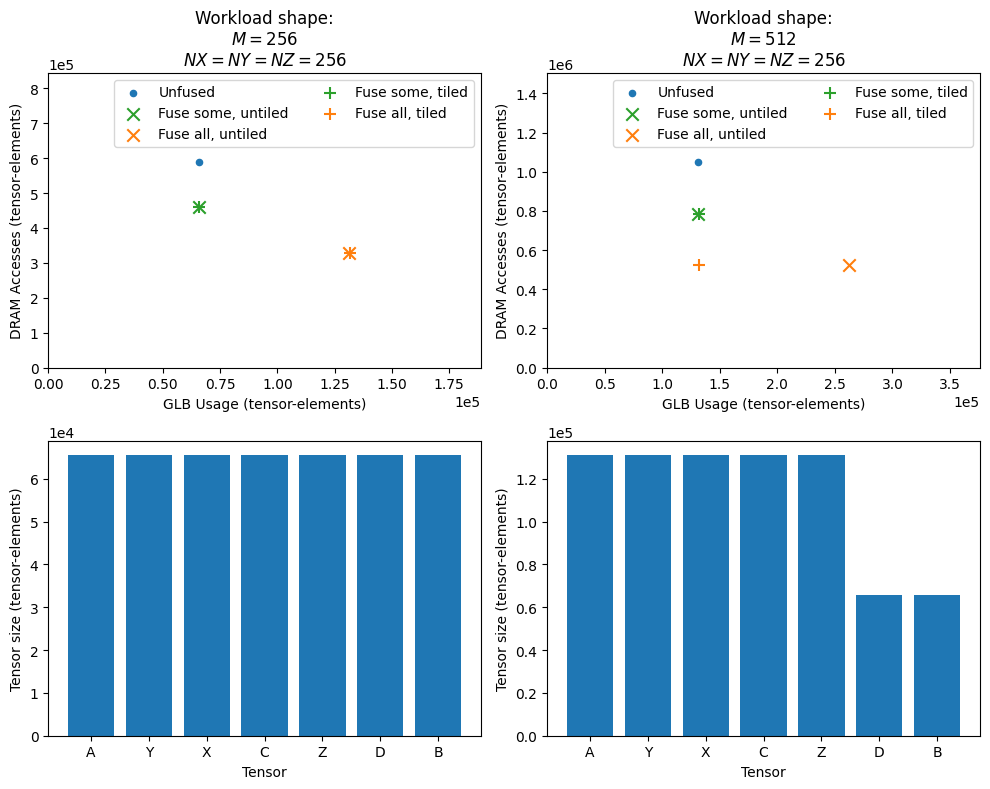

In [34]:
from functools import reduce
from operator import mul

shapes = [
    {"M": 256, "N": 256},
    {"M": 512, "N": 256},
]
mappings = {
    "Unfused": "unfused.yaml",
    "Fuse some, untiled": "fuse_some_untiled.yaml",
    "Fuse all, untiled": "fuse_all_untiled.yaml",
    "Fuse some, tiled": "fuse_some_tiled.yaml",
    "Fuse all, tiled": "fuse_all_tiled.yaml",
}

fig, axes = plt.subplots(2, len(shapes), figsize=(10, 8))
for ax, shape in zip(axes[0,:], shapes):
    for name, mapping_yaml in mappings.items():
        result = af.Spec.from_yaml(
            f"mapping/{mapping_yaml}",
            "workload/matmul_add_matmul.yaml",
            "arch/simple_scalar.yaml",
            jinja_parse_data={"M": shape["M"], "N": shape["N"], "GLB_SIZE": GLB_SIZE},
        ).evaluate_mapping()
        if "Unfused" in name:
            marker = '.'
            color = 'tab:blue'
        if "tiled" in name:
            marker = '+'
        if "untiled" in name:
            marker = 'x'
        if "Fuse all" in name:
            color = 'tab:orange'
        if "Fuse some" in name:
            color = 'tab:green'
        ax.scatter(
            result.resource_usage()["GLB"]*GLB_SIZE/8,
            (result.actions()["DRAM", "read"] + result.actions()["DRAM", "write"])/8,
            c=color,
            label=name,
            marker=marker,
            s=80,
        )
    ax.legend(ncol=2)
    xlim = ax.get_xlim()
    ax.set_xlim((0, xlim[1]*1.4))
    ylim = ax.get_ylim()
    ax.set_ylim((0, ylim[1]*1.4))
    ax.ticklabel_format(scilimits=(-2, 3))
    ax.set_ylabel("DRAM Accesses (tensor-elements)")
    ax.set_xlabel("GLB Usage (tensor-elements)")
    ax.set_title(f"Workload shape:\n$M={shape["M"]}$\n$NX=NY=NZ={shape["N"]}$")
for ax, shape in zip(axes[1,:], shapes):
    spec = af.Spec.from_yaml(
        "workload/matmul_add_matmul.yaml",
        jinja_parse_data={"M": shape["M"], "N": shape["N"], "GLB_SIZE": GLB_SIZE},
    )
    tensor_sizes = [
        reduce(mul, spec.workload.get_tensor_shape(tensor).values())
        for tensor in spec.workload.tensor_names
    ]
    ax.ticklabel_format(scilimits=(-2, 3))
    ax.bar(list(spec.workload.tensor_names), tensor_sizes)
    ax.set_ylabel("Tensor size (tensor-elements)")
    ax.set_xlabel("Tensor")
fig.tight_layout()

Please answer the questions below.

In [35]:
# Fusing more doesn't always increase GLB usage ~2x regardless of workload shape.
# For some shapes, the increase can be much less significant.
answer(
    "2.4.1",
    """
    True/False: Fusing more always increases GLB usage significantly (~2x)
    compared to fusing some and unfused, regardless of workload shape.
    """,
    required_type=bool,
    answer= False,
)

# For fuse_some_tiled: X is tiled from M*NX to M*1 = huge reduction (NX-fold).
# This is a significant reduction.
answer(
    "2.4.2",
    """
    True/False: Tiling shared tensors lead to significant reduction in GLB
    usage for "Fuse some" in some workload shape.
    """,
    required_type=bool,
    answer= True,
)

# For fuse_all_tiled with M=512: X and Y tiles are small (256 each),
# vs untiled X=131072, Y=131072. Significant reduction for larger M.
answer(
    "2.4.3",
    """
    True/False: Tiling shared tensors lead to significant reduction in GLB
    usage for "Fuse all" in some workload shape.
    """,
    required_type=bool,
    answer= True,
)

2.4.1: 
    True/False: Fusing more always increases GLB usage significantly (~2x)
    compared to fusing some and unfused, regardless of workload shape.
    
	False
2.4.2: 
    True/False: Tiling shared tensors lead to significant reduction in GLB
    usage for "Fuse some" in some workload shape.
    
	True


2.4.3: 
    True/False: Tiling shared tensors lead to significant reduction in GLB
    usage for "Fuse all" in some workload shape.
    
	True


Now, we will analyze the mappings to better understand these observations.

Run the cell below and observe again the "Fuse some, tiled" mapping:

In [36]:
spec = af.Spec.from_yaml(
    f"mapping/fuse_some_tiled.yaml",
    "workload/matmul_add_matmul.yaml",
    "arch/simple_scalar.yaml",
    jinja_parse_data={"M": shape["M"], "N": shape["N"], "GLB_SIZE": GLB_SIZE},
)
spec.mapping

FileNotFoundError: [Errno 2] "dot" not found in path.

Mapping(nodes=[Storage(tensors=['A', 'B', 'C', 'D', 'Y', 'Z'], component='DRAM', component_object=None, persistent=False), Sequential(nodes=[Nested(nodes=[Storage(tensors=['A'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='nx', tile_shape=1, initial_tile_shape=None), Storage(tensors=['X'], component='GLB', component_object=None, persistent=False), Sequential(nodes=[Nested(nodes=[Temporal(rank_variable='na', tile_shape=1, initial_tile_shape=None), Storage(tensors=['B'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='m', tile_shape=1, initial_tile_shape=None), Compute(einsum='EinsumX', component='MAC', component_object=None)]), Nested(nodes=[Temporal(rank_variable='m', tile_shape=1, initial_tile_shape=None), Compute(einsum='EinsumY', component='MAC', component_object=None)])])]), Nested(nodes=[Storage(tensors=['D'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='m', tile_shape=1,

Please answer the following questions.

In [37]:
# In fuse_some_tiled: A is stored in GLB above the nx loop (full A[M,NA])
# A = M*NA = largest tensor in GLB for both shapes, especially for M=512
answer(
    "2.4.4",
    """
    In the mapping above, which one tensor constitute the most to GLB usage in
    *both* workload shapes?

    Hint: There is one tensor that contributes the most to GLB usage for the
    M=512 workload.

    More hint: Remember that placement of storage node relative to loop nodes
    determine the shape of the tile kept in the memory level, and the tile is
    what determines usage.
    """,
    required_type=set[str],
    answer= {'A'},
)

2.4.4: 
    In the mapping above, which one tensor constitute the most to GLB usage in
    *both* workload shapes?

    Hint: There is one tensor that contributes the most to GLB usage for the
    M=512 workload.

    More hint: Remember that placement of storage node relative to loop nodes
    determine the shape of the tile kept in the memory level, and the tile is
    what determines usage.
    
	{'A'}


Now, we look at the "Fuse all, tiled" mappings.
Please run the cell below.

In [38]:
spec = af.Spec.from_yaml(
    f"mapping/fuse_all_tiled.yaml",
    "workload/matmul_add_matmul.yaml",
    "arch/simple_scalar.yaml",
    jinja_parse_data={"M": shape["M"], "N": shape["N"], "GLB_SIZE": GLB_SIZE},
)
spec.mapping

FileNotFoundError: [Errno 2] "dot" not found in path.

Mapping(nodes=[Storage(tensors=['A', 'B', 'C', 'D', 'Z'], component='DRAM', component_object=None, persistent=False), Storage(tensors=['B', 'D'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='m', tile_shape=1, initial_tile_shape=None), Storage(tensors=['X', 'Y'], component='GLB', component_object=None, persistent=False), Sequential(nodes=[Nested(nodes=[Temporal(rank_variable='na', tile_shape=1, initial_tile_shape=None), Storage(tensors=['A'], component='GLB', component_object=None, persistent=False), Temporal(rank_variable='nx', tile_shape=1, initial_tile_shape=None), Compute(einsum='EinsumX', component='MAC', component_object=None)]), Nested(nodes=[Temporal(rank_variable='nx', tile_shape=1, initial_tile_shape=None), Compute(einsum='EinsumY', component='MAC', component_object=None)]), Nested(nodes=[Temporal(rank_variable='nz', tile_shape=1, initial_tile_shape=None), Storage(tensors=['Z'], component='GLB', component_object=None, persistent=False), Te

Now, answer the following questions.

In [39]:
# B and D are stored in GLB above the m loop (no tiling above them)
# They are kept in their entirety
answer(
    "2.4.5",
    """
    In the "Fuse all, tiled" mapping above, which tensor(s) are kept in their
    entirety in the GLB?

    Hint: look at the placement of storage nodes relative to loop nodes.
    """,
    required_type=set[str],
    answer= {'B', 'D'},
)

# With M=512, N=256: B[NA,NX]=65536, D[NY,NZ]=65536 are smallest
# All other tensors have M dimension (512*256=131072)
answer(
    "2.4.6",
    """
    In the workload with M=512, which tensor(s) are the smallest tensors?

    Do not consider the mapping in this question, base your answer only on the
    workload.
    """,
    required_type=set[str],
    answer= {'B', 'D'},
)

# Yes: B and D (smallest) kept in entirety, X, Y, A, Z (larger) are tiled
answer(
    "2.4.7",
    """
    True/False: The "Fuse all, tiled" mapping keeps only tiles of the largest
    tensors in GLB, and keeps only smaller tensors in entirety.
    """,
    required_type=bool,
    answer= True,
)

2.4.5: 
    In the "Fuse all, tiled" mapping above, which tensor(s) are kept in their
    entirety in the GLB?

    Hint: look at the placement of storage nodes relative to loop nodes.
    
	{'D', 'B'}
2.4.6: 
    In the workload with M=512, which tensor(s) are the smallest tensors?

    Do not consider the mapping in this question, base your answer only on the
    workload.
    
	{'D', 'B'}
2.4.7: 
    True/False: The "Fuse all, tiled" mapping keeps only tiles of the largest
    tensors in GLB, and keeps only smaller tensors in entirety.
    
	True


Given the observations above, we now see that fusion is often a trade-off between increased GLB usage for lower DRAM accesses.
Moreover, the exact amounts traded-off depends on the workload shape, which also determines whether that trade-off is beneficial.

Finally, we should note that we compared only single mappings from a large space of mappings that fuse or tile.
Although the mappings we analyzed in this section have been chosen to demonstrate certain important lessons, a better comparison should compare the most optimized mapping from each category, which requires a mapper to find.

## Section 3: Designing High-Throughput Accelerators

For this part, consider a cascade of two matrix multiplications:

$$
Y_{m,ny} = A_{m,na} \times B_{na,ny}
$$

$$
Z_{m,nz} = Y_{m,ny} \times C_{ny,nz}
$$

You must design an architecture within an area constraint to optimize throughput and energy-efficiency.

The accelerator is connected to an off-chip DRAM with the given bandwidth `DRAM_BW`. Moreover, the accelerator has an array of computation units that uses a weight-stationary dataflow.

### Question 1: Your Design

Please run the following cell to set constant parameters.

In [40]:
# DO NOT RECONFIGURE THESE. Constant architectural parameters
DRAM_BW = 8
ALLOWED_AREA = 0.0017
BASELINE_EDP = 0.0077

# Rank shapes
M = 4096
NA = 4096
NY = 4096*4
NZ = 4096

# Utility function for getting minimum EDP from the mapper. You don't need to worry about this.
def min_edp_filter(df):
    edp = df["Total<SEP>energy"]*df["Total<SEP>latency"]
    return edp.argmin()

In the cell below, you can change the global buffer (GLB) capacity and bandwidth, register file (RF) capacity, and the shape of the computation unit array.
Moreover, in each level of memory hierarchy, you must designate which tensor(s) are kept in that level.

In [41]:
#### EXAMPLE START ####
# # This is an example of two levels of memory hierarchy. From furthest to closest to the MAC: DRAM, L2, L1, and MAC.
# # Capacity is in #tensor-elements and bandwidth is in #tensor-elements/cycle.
# # The key "keep" determines what tensor is kept in that memory level.
# final_memory_hierarchy = [
#     {"name": "L2", "capacity": 1024*1024, "bandwidth": 4, "keep": "Y | Z"},
# ]
# final_array_x = 8
# final_array_y = 8
# final_rf_capacity = 1
#### EXAMPLE END ####
#### SOLUTION START ####
final_memory_hierarchy = [
    {"name": "L2", "capacity": 32*1024*1024, "bandwidth": 256, "keep": "Y | A | Z"},
    {"name": "L1", "capacity": 1*1024*1024, "bandwidth": 512, "keep": "output"},
]
final_array_x = 128
final_array_y = 128
final_rf_capacity = 8
#### SOLUTION END ####

Please run the following cell to evaluate your final design.

In [42]:
spec = af.Spec.from_yaml(
    "arch/scaffold.yaml",
    "workload/matmul_matmul.yaml",
    jinja_parse_data=dict(
        M=M,
        NA=NA, 
        NY=NY,
        NZ=NZ,
        DRAM_BW=DRAM_BW,
        memory_hierarchy=final_memory_hierarchy,
        array_x=final_array_x,
        array_y=final_array_y,
        rf_capacity=final_rf_capacity,
        rf_keep=" & ".join(["~DRAM"] + [f"~{level["name"]}" for level in final_memory_hierarchy])
    )
)
spec.mapper.metrics = Metrics.LATENCY | Metrics.ENERGY
area = spec.calculate_component_area_energy_latency_leak().arch.total_area
mappings = spec.map_workload_to_arch()
mappings = mappings[min_edp_filter(mappings.data)]

print("Your area is", area)
answer(
    "3.1.1",
    "Is the memory hierarchy area within the allowed area?",
    required_type=bool,
    answer=area <= ALLOWED_AREA,
)
from math import exp

def score(edp):
    ratio = edp/BASELINE_EDP
    if ratio > 10:
        return 0.0
    return min(100, 100/exp(ratio - 1))

edp = (mappings.data["Total<SEP>energy"]*mappings.data["Total<SEP>latency"]).min()
print("Your EDP is", edp, "pJ*s")

answer(
    "3.1.2",
    "Your score is:",
    required_type=Number,
    answer=score(edp)
)

### END OF DO-NOT-MODIFY BLOCK ###

Getting energy, latency, and leak power for components running :   0%|          | 0/2 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running EinsumY:   0%|          | 0/2 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running EinsumY:  50%|█████     | 1/2 [00:00<00:00,  8.96it/s]

Getting energy, latency, and leak power for components running EinsumZ:  50%|█████     | 1/2 [00:00<00:00,  8.96it/s]

Getting energy, latency, and leak power for components running EinsumZ: 100%|██████████| 2/2 [00:00<00:00,  9.79it/s]

Generating jobs:   0%|          | 0/2 [00:00<?, ?it/s]

Generating pmapping templates for compute MAC Einsum EinsumZ: 0it [00:00, ?it/s]

Generating pmapping templates for compute MAC Einsum EinsumZ: 6it [00:00, 57.84it/s]

Generating pmapping templates for compute MAC Einsum EinsumZ: 15it [00:00, 71.51it/s]

Generating pmapping templates for compute MAC Einsum EinsumZ: 23it [00:00, 75.01it/s]

Generating pmapping templates for compute MAC Einsum EinsumZ: 31it [00:00, 76.15it/s]

Generating pmapping templates for compute MAC Einsum EinsumZ: 44it [00:00, 85.91it/s]
Generating jobs:  50%|█████     | 1/2 [00:00<00:00,  1.58it/s]

Generating pmapping templates for compute MAC Einsum EinsumY: 44it [00:00, 67.92it/s]


Generating jobs: 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

Generating jobs: 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

Einsum EinsumY has 44 pmapping templates:
	0	[B in DRAM] [A in DRAM] T-m  T-ny  [A in L2] T-ny  [Y in L2] T-m  T-ny  [Y in L1] T-na  S-Y-ny  S-X-na  [B in RF] T-m  MAC computes EinsumY
	1	[B in DRAM] [A in DRAM] T-m  T-ny  [A in L2] T-ny  [Y in L2] T-m  T-ny  [Y in L1] T-na  S-Y-ny  S-X-na  [A in RF] T-ny  [B in RF] T-m  MAC computes EinsumY
	2	[B in DRAM] [A in DRAM] T-m  T-ny  [A in L2] T-ny  [Y in L2] T-m  T-ny  [Y in L1] T-na  S-Y-ny  S-X-na  [B in RF] T-m  [A in RF] T-ny  MAC computes EinsumY
	3	[B in DRAM] [A in DRAM] T-m  T-ny  [A in L2] T-ny  [Y in L2] T-m  T-ny  [Y in L1] T-na  S-Y-ny  S-X-na  [B in RF] T-m  [Y in RF] T-na  MAC computes EinsumY
	4	[B in DRAM] [A in DRAM] T-m  T-ny  [A in L2] T-ny  [Y in L2] T-m  T-ny  [Y in L1] S-Y-ny  S-X-na  [Y in RF] T-na  [B in RF] T-m  MAC computes EinsumY
	5	[B in DRAM] [A in DRAM] T-m  T-ny  [A in L2] T-ny  [Y in L2] T-m  T-ny  [Y in L1] T-na  S-Y-ny  S-X-na  [A in RF] T-ny  [B in RF] T-m  [Y in RF] T-na  MAC computes EinsumY
	6	[B in D

Generating pmappings:   0%|          | 0/88 [00:00<?, ?it/s]

Generating pmappings:   1%|          | 1/88 [00:14<21:25, 14.77s/it]

Generating pmappings:   2%|▏         | 2/88 [00:17<10:59,  7.67s/it]

Generating pmappings:   3%|▎         | 3/88 [00:18<06:31,  4.61s/it]

Generating pmappings:   5%|▍         | 4/88 [00:19<04:22,  3.13s/it]

Generating pmappings:   6%|▌         | 5/88 [00:19<03:03,  2.21s/it]

Generating pmappings:   8%|▊         | 7/88 [00:20<01:38,  1.22s/it]

Generating pmappings:   9%|▉         | 8/88 [00:20<01:15,  1.06it/s]

Generating pmappings:  11%|█▏        | 10/88 [00:20<00:48,  1.59it/s]

Generating pmappings:  14%|█▎        | 12/88 [00:21<00:34,  2.22it/s]

Generating pmappings:  16%|█▌        | 14/88 [00:21<00:24,  2.97it/s]

Generating pmappings:  17%|█▋        | 15/88 [00:22<00:32,  2.21it/s]

Generating pmappings:  19%|█▉        | 17/88 [00:22<00:25,  2.82it/s]

Generating pmappings:  22%|██▏       | 19/88 [00:23<00:19,  3.56it/s]

Generating pmappings:  23%|██▎       | 20/88 [00:23<00:20,  3.32it/s]

Generating pmappings:  24%|██▍       | 21/88 [00:23<00:20,  3.24it/s]

Generating pmappings:  25%|██▌       | 22/88 [00:24<00:22,  2.99it/s]

Generating pmappings:  26%|██▌       | 23/88 [00:25<00:31,  2.06it/s]

Generating pmappings:  27%|██▋       | 24/88 [00:25<00:24,  2.61it/s]

Generating pmappings:  30%|██▉       | 26/88 [00:26<00:23,  2.60it/s]

Generating pmappings:  31%|███       | 27/88 [00:26<00:20,  2.98it/s]

Generating pmappings:  33%|███▎      | 29/88 [00:26<00:15,  3.87it/s]

Generating pmappings:  34%|███▍      | 30/88 [00:27<00:19,  2.99it/s]

Generating pmappings:  36%|███▋      | 32/88 [00:27<00:13,  4.24it/s]

Generating pmappings:  39%|███▊      | 34/88 [00:28<00:22,  2.38it/s]

Generating pmappings:  43%|████▎     | 38/88 [00:29<00:11,  4.19it/s]

Generating pmappings:  45%|████▌     | 40/88 [00:29<00:11,  4.21it/s]

Generating pmappings:  47%|████▋     | 41/88 [00:29<00:10,  4.36it/s]

Generating pmappings:  48%|████▊     | 42/88 [00:29<00:10,  4.19it/s]

Generating pmappings:  49%|████▉     | 43/88 [00:30<00:15,  2.81it/s]

Generating pmappings:  50%|█████     | 44/88 [00:30<00:13,  3.24it/s]

Generating pmappings:  51%|█████     | 45/88 [00:31<00:12,  3.43it/s]

Generating pmappings:  52%|█████▏    | 46/88 [00:31<00:10,  3.91it/s]

Generating pmappings:  53%|█████▎    | 47/88 [00:31<00:10,  4.09it/s]

Generating pmappings:  55%|█████▍    | 48/88 [00:31<00:08,  4.55it/s]

Generating pmappings:  57%|█████▋    | 50/88 [00:32<00:08,  4.67it/s]

Generating pmappings:  58%|█████▊    | 51/88 [00:32<00:07,  4.66it/s]

Generating pmappings:  60%|██████    | 53/88 [00:32<00:05,  6.35it/s]

Generating pmappings:  61%|██████▏   | 54/88 [00:32<00:06,  5.53it/s]

Generating pmappings:  62%|██████▎   | 55/88 [00:32<00:05,  5.88it/s]

Generating pmappings:  64%|██████▎   | 56/88 [00:33<00:05,  5.77it/s]

Generating pmappings:  65%|██████▍   | 57/88 [00:33<00:08,  3.61it/s]

Generating pmappings:  68%|██████▊   | 60/88 [00:33<00:05,  5.35it/s]

Generating pmappings:  72%|███████▏  | 63/88 [00:34<00:03,  8.27it/s]

Generating pmappings:  74%|███████▍  | 65/88 [00:34<00:03,  7.21it/s]

Generating pmappings:  76%|███████▌  | 67/88 [00:34<00:02,  7.71it/s]

Generating pmappings:  78%|███████▊  | 69/88 [00:34<00:02,  7.97it/s]

Generating pmappings:  81%|████████  | 71/88 [00:35<00:02,  8.45it/s]

Generating pmappings:  83%|████████▎ | 73/88 [00:35<00:02,  6.43it/s]

Generating pmappings:  86%|████████▋ | 76/88 [00:35<00:01,  8.18it/s]

Generating pmappings:  88%|████████▊ | 77/88 [00:35<00:01,  8.14it/s]

Generating pmappings:  89%|████████▊ | 78/88 [00:36<00:01,  8.06it/s]

Generating pmappings:  91%|█████████ | 80/88 [00:36<00:00,  8.81it/s]

Generating pmappings:  92%|█████████▏| 81/88 [00:36<00:00,  8.23it/s]

Generating pmappings:  94%|█████████▍| 83/88 [00:36<00:00,  9.28it/s]

Generating pmappings:  97%|█████████▋| 85/88 [00:36<00:00, 10.91it/s]

Generating pmappings:  99%|█████████▉| 87/88 [00:37<00:00,  4.41it/s]

Generating pmappings: 100%|██████████| 88/88 [00:37<00:00,  4.76it/s]

Generating pmappings: 100%|██████████| 88/88 [00:37<00:00,  2.33it/s]

Grouping pmappings for EinsumY:   0%|          | 0/5 [00:00<?, ?it/s]

Grouping pmappings for EinsumY:  20%|██        | 1/5 [00:00<00:00,  8.10it/s]

Grouping pmappings for EinsumY: 100%|██████████| 5/5 [00:00<00:00, 12.75it/s]

Grouping pmappings for EinsumY: 100%|██████████| 5/5 [00:00<00:00, 12.28it/s]

Grouping pmappings for EinsumZ:   0%|          | 0/5 [00:00<?, ?it/s]

Grouping pmappings for EinsumZ:  40%|████      | 2/5 [00:00<00:00, 18.03it/s]

Grouping pmappings for EinsumZ: 100%|██████████| 5/5 [00:00<00:00, 12.82it/s]

Grouping pmappings for EinsumZ: 100%|██████████| 5/5 [00:00<00:00, 13.23it/s]

EinsumY: 2.89e08 total, 5.48e05 (1/527) valid, 5.21e06 (1/56) evaluated, 8.52e03 (1/3.39e04) Pareto-Optimal
EinsumZ: 1.81e08 total, 3.68e05 (1/491) valid, 2.81e06 (1/64) evaluated, 5.75e03 (1/3.14e04) Pareto-Optimal
Total: 4.70e08 total, 9.16e05 (1/513) valid, 8.01e06 (1/59) evaluated, 1.43e04 (1/3.29e04) Pareto-Optimal


Compressing pmappings:   0%|          | 0/2 [00:00<?, ?it/s]

Compressing pmappings: 100%|██████████| 2/2 [00:00<00:00, 27.48it/s]

Joining pmappings for EinsumY <--> EinsumZ (2/2):   0%|          | 0/7 [00:00<?, ?it/s]

Joining pmappings for EinsumY <--> EinsumZ (2/2): 100%|██████████| 7/7 [00:00<00:00, 55.83it/s]

Joining pmappings for EinsumY <--> EinsumZ (2/2): 100%|██████████| 7/7 [00:00<00:00, 55.07it/s]

Final consolidate:   0%|          | 0/7 [00:00<?, ?it/s]

Final consolidate: 100%|██████████| 7/7 [00:00<00:00, 324.44it/s]

Grouping pmappings:   0%|          | 0/1 [00:00<?, ?it/s]

Grouping pmappings: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

Grouping pmappings: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

Evaluating chosen mappings in detail:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating chosen mappings in detail:  50%|█████     | 1/2 [00:00<00:00,  3.37it/s]

Evaluating chosen mappings in detail: 100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

Your area is 7.378196161600001e-05
3.1.1: Is the memory hierarchy area within the allowed area?
	True
Your EDP is 0.00753104404519797 pJ*s
3.1.2: Your score is:
	100


### Question 2: Some Tools to Analyze Your Design and Help Your Design Process

None of the following cells are graded, but they are provide immensely useful visualizations of energy and latency to help your design process.

You can create different architectures and insert them as a value in the dictionary `EXPERIMENTS` with a name of your choosing as the key.
The example given in Question 1 is included in `EXPERIMENTS` with name `"default"`.
We will call the mapper on every configuration in `EXPERIMENTS` and record the results.
The following cells will provide visualizations of those results.

In [43]:
# Holds a dict mapping name of experiment (of your choosing) to the memory hierarchy
# An example is provided, and you can add more here to keep track of your designs.
EXPERIMENTS = {}
DEFAULT_CONFIGURATION = {
    "memory_hierarchy": [
        {"name": "L2", "capacity": 1024*1024, "bandwidth": 4, "keep": "Y"},
    ],
    "array_x": 8,
    "array_y": 8,
    "rf_capacity": 4,
}
EXPERIMENTS["default"] = DEFAULT_CONFIGURATION
########################
#### YOUR CODE HERE ####
########################


# Holds mappings that result from the mapping search for each experiment
MAPPINGS = {}
# Holds areas of the architecture using the memory hierarchy of each experiment
AREAS = {}

for experiment in EXPERIMENTS:
    memory_hierarchy = EXPERIMENTS[experiment]["memory_hierarchy"]
    array_x = EXPERIMENTS[experiment]["array_x"]
    array_y = EXPERIMENTS[experiment]["array_y"]
    rf_capacity = EXPERIMENTS[experiment]["rf_capacity"]
    spec = af.Spec.from_yaml(
        "arch/scaffold.yaml",
        "workload/matmul_matmul.yaml",
        jinja_parse_data=dict(
            M=M,
            NA=NA, 
            NY=NY,
            NZ=NZ,
            DRAM_BW=DRAM_BW,
            memory_hierarchy=memory_hierarchy,
            array_x=array_x,
            array_y=array_y,
            rf_capacity=rf_capacity,
        )
    )
    spec.mapper.metrics = Metrics.LATENCY | Metrics.ENERGY
    area = spec.calculate_component_area_energy_latency_leak().arch.total_area
    mappings = spec.map_workload_to_arch()
    mappings = mappings[min_edp_filter(mappings.data)]
    MAPPINGS[experiment] = mappings
    AREAS[experiment] = area

Getting energy, latency, and leak power for components running :   0%|          | 0/2 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running EinsumY:   0%|          | 0/2 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running EinsumZ:   0%|          | 0/2 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running EinsumZ: 100%|██████████| 2/2 [00:00<00:00, 33.88it/s]

Generating jobs:   0%|          | 0/2 [00:00<?, ?it/s]

Generating pmapping templates for compute MAC Einsum EinsumY: 22it [00:00, 207.05it/s]


Generating jobs:  50%|█████     | 1/2 [00:00<00:00,  6.56it/s]

Generating pmapping templates for compute MAC Einsum EinsumZ: 22it [00:00, 136.78it/s]
Generating jobs: 100%|██████████| 2/2 [00:00<00:00,  8.77it/s]

Einsum EinsumY has 22 pmapping templates:
	0	[B in DRAM] [A in DRAM] T-m  T-ny  [Y in L2] T-na  T-ny  S-Y-ny  S-X-na  [B in RF] T-m  MAC computes EinsumY
	1	[B in DRAM] [A in DRAM] T-m  T-ny  [Y in L2] T-m  T-na  S-Y-ny  S-X-na  [A in RF] T-ny  [B in RF] T-m  MAC computes EinsumY
	2	[B in DRAM] [A in DRAM] T-m  T-ny  [Y in L2] T-na  T-ny  S-Y-ny  S-X-na  [B in RF] T-m  [A in RF] T-ny  MAC computes EinsumY
	3	[B in DRAM] [A in DRAM] T-m  T-ny  [Y in L2] T-na  T-ny  S-Y-ny  S-X-na  [B in RF] T-m  [Y in RF] T-na  MAC computes EinsumY
	4	[B in DRAM] [A in DRAM] T-m  T-ny  [Y in L2] T-m  T-ny  S-Y-ny  S-X-na  [Y in RF] T-na  [B in RF] T-m  MAC computes EinsumY
	5	[B in DRAM] [A in DRAM] T-m  T-ny  [Y in L2] T-m  T-na  S-Y-ny  S-X-na  [A in RF] T-ny  [B in RF] T-m  [Y in RF] T-na  MAC computes EinsumY
	6	[B in DRAM] [A in DRAM] T-m  T-ny  [Y in L2] T-m  T-na  S-Y-ny  S-X-na  [A in RF] T-ny  [Y in RF] T-na  [B in RF] T-m  MAC computes EinsumY
	7	[B in DRAM] [A in DRAM] T-m  T-ny  [Y in L2] T-

Generating pmappings:   0%|          | 0/44 [00:00<?, ?it/s]

Generating pmappings:   2%|▏         | 1/44 [00:00<00:24,  1.72it/s]

Generating pmappings:   7%|▋         | 3/44 [00:00<00:12,  3.28it/s]

Generating pmappings:  11%|█▏        | 5/44 [00:01<00:06,  5.70it/s]

Generating pmappings:  23%|██▎       | 10/44 [00:01<00:03, 11.16it/s]

Generating pmappings:  32%|███▏      | 14/44 [00:01<00:02, 12.94it/s]

Generating pmappings:  36%|███▋      | 16/44 [00:01<00:02, 12.13it/s]

Generating pmappings:  45%|████▌     | 20/44 [00:01<00:01, 14.07it/s]

Generating pmappings:  55%|█████▍    | 24/44 [00:02<00:01, 18.36it/s]

Generating pmappings:  61%|██████▏   | 27/44 [00:02<00:00, 20.45it/s]

Generating pmappings:  68%|██████▊   | 30/44 [00:02<00:00, 19.40it/s]

Generating pmappings:  77%|███████▋  | 34/44 [00:02<00:00, 22.36it/s]

Generating pmappings:  86%|████████▋ | 38/44 [00:02<00:00, 24.44it/s]

Generating pmappings:  93%|█████████▎| 41/44 [00:02<00:00, 23.34it/s]

Generating pmappings: 100%|██████████| 44/44 [00:02<00:00, 15.42it/s]

Grouping pmappings for EinsumY:   0%|          | 0/4 [00:00<?, ?it/s]

Grouping pmappings for EinsumY: 100%|██████████| 4/4 [00:00<00:00, 38.28it/s]

Grouping pmappings for EinsumY: 100%|██████████| 4/4 [00:00<00:00, 37.75it/s]

Grouping pmappings for EinsumZ:   0%|          | 0/4 [00:00<?, ?it/s]

Grouping pmappings for EinsumZ: 100%|██████████| 4/4 [00:00<00:00, 41.68it/s]

EinsumY: 6.44e06 total, 886 (1/7.27e03) valid, 4.98e04 (1/129) evaluated, 320 (1/2.01e04) Pareto-Optimal
EinsumZ: 6.44e06 total, 3.53e03 (1/1.82e03) valid, 4.98e04 (1/129) evaluated, 231 (1/2.79e04) Pareto-Optimal
Total: 1.29e07 total, 4.42e03 (1/2.92e03) valid, 9.96e04 (1/129) evaluated, 551 (1/2.34e04) Pareto-Optimal


Compressing pmappings:   0%|          | 0/2 [00:00<?, ?it/s]

Compressing pmappings: 100%|██████████| 2/2 [00:00<00:00, 62.65it/s]

Joining pmappings for EinsumY <--> EinsumZ (2/2):   0%|          | 0/4 [00:00<?, ?it/s]

Joining pmappings for EinsumY <--> EinsumZ (2/2): 100%|██████████| 4/4 [00:00<00:00, 126.22it/s]

Final consolidate:   0%|          | 0/4 [00:00<?, ?it/s]

Final consolidate: 100%|██████████| 4/4 [00:00<00:00, 340.54it/s]

Grouping pmappings:   0%|          | 0/1 [00:00<?, ?it/s]

Grouping pmappings: 100%|██████████| 1/1 [00:00<00:00, 117.15it/s]

Evaluating chosen mappings in detail:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating chosen mappings in detail:  50%|█████     | 1/2 [00:00<00:00,  4.58it/s]

Evaluating chosen mappings in detail: 100%|██████████| 2/2 [00:00<00:00,  8.10it/s]

The following cell plots a comparison of total energy for all experiments you included in `EXPERIMENTS`.
The x-axis labels follows the format "ExperimentName-mx" where each mx is a mapping.
You should only ever see m0 in this exploration, but in general the mapper may return an entire trade-off curve (m0 is the first mapping in the curve, m1 is the second mapping, and so on).

(<Figure size 100x400 with 1 Axes>, <Axes: ylabel='Energy (pJ)'>)

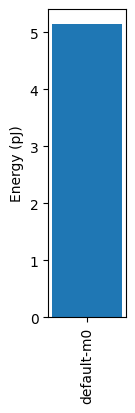

In [44]:
plot_energy_comparison(list(MAPPINGS.values()), labels=list(MAPPINGS.keys()))

This cell compares latencies of your designs.

(<Figure size 100x400 with 1 Axes>, <Axes: ylabel='Latency (s)'>)

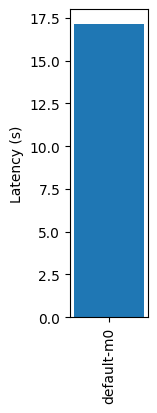

In [45]:
plot_latency_comparison(list(MAPPINGS.values()), labels=list(MAPPINGS.keys()))

The following cell plots the energy breakdown by component (see AccelForge API docs for more options) for all experiments.

/home/fisherxue/65931S2026/accelforge/accelforge/plotting/mappings.py:165: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


(<Figure size 300x400 with 1 Axes>,
 [<Axes: title={'center': 'default-m0'}, ylabel='Energy (pJ)'>])

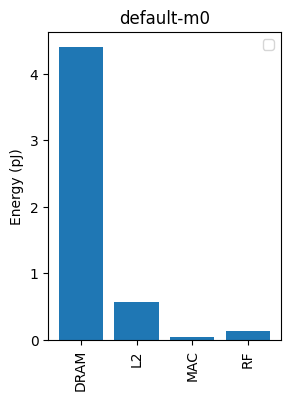

In [46]:
plot_energy_breakdown(list(MAPPINGS.values()), separate_by=["component"], labels=list(MAPPINGS.keys()))

The following cell compares the areas of each experiment.

<BarContainer object of 1 artists>

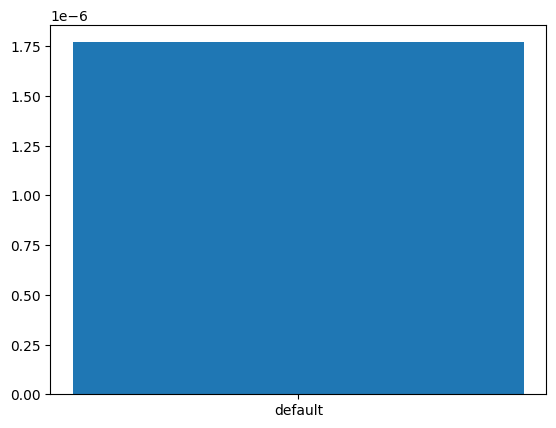

In [47]:
plt.bar(AREAS.keys(), AREAS.values())

Finally, you can run the following cell to render the minimum EDP mapping found for each architecture.
You will find this cell to be very helpful in identifying optimization opportunities since reading the mapping
will help you understand how the architectural resources you provisioned (memory capacities, spatial arrays)
are being used.

**Note**: the following render includes additional information in the LoopTree, such as the number of iterations
in each loop node (in addition to tile shapes). These iterations can be interpreted as the bounds of the loops.
Moreover, *reservation* nodes are shown. These nodes explicitly show the lifetimes of tensors.
As such, reservation nodes often show up exactly where storage nodes are.
However, if a storage node is right above a split, reservation nodes are created underneath the split in each Einsum for which the tensor lives (this is why we say reservation nodes are *explicit* about the lifetimes).

In [48]:
# MAPPINGS["default"].render()  # Requires graphviz 'dot' to be installed
print("Skipping render (graphviz not available)")

Skipping render (graphviz not available)


That is it! Now, you should be well equipped to explore the design space.

## Section 4: Ski-slope Bounds and Designing with Them
As you have experienced, designing memory hierarchies can require a lot of trials and errors.
In this section, we'll learn about ski-slope bounds, which can help you in your design.

The *ski-slope bound* is a curve that, for a given on-chip memory capacity, shows the theoretical minimum off-chip data movement.
The bound is architecture agnostic, and depends only on the workload.

The following cell generates the ski-slope curve for a matrix multiplication workload. Run the cell.

Getting energy, latency, and leak power for components running :   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running EinsumZ:   0%|          | 0/1 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running EinsumZ: 100%|██████████| 1/1 [00:00<00:00, 63.98it/s]

Generating jobs:   0%|          | 0/1 [00:00<?, ?it/s]

Generating pmapping templates for compute MAC Einsum EinsumZ: 0it [00:00, ?it/s]

Generating pmapping templates for compute MAC Einsum EinsumZ: 6it [00:00, 256.12it/s]


Generating jobs: 100%|██████████| 1/1 [00:00<00:00, 26.58it/s]

Einsum EinsumZ has 6 pmapping templates:
	0	[Z in MainMemory] [B in MainMemory] [A in MainMemory] T-k  T-m  [A in GlobalBuffer] T-n  [B in GlobalBuffer] T-m  [Z in GlobalBuffer] T-k  MAC computes EinsumZ
	1	[Z in MainMemory] [B in MainMemory] [A in MainMemory] T-k  T-m  [A in GlobalBuffer] T-n  [Z in GlobalBuffer] T-k  [B in GlobalBuffer] T-m  MAC computes EinsumZ
	2	[Z in MainMemory] [B in MainMemory] [A in MainMemory] T-k  T-n  [B in GlobalBuffer] T-m  [A in GlobalBuffer] T-n  [Z in GlobalBuffer] T-k  MAC computes EinsumZ
	3	[Z in MainMemory] [B in MainMemory] [A in MainMemory] T-k  T-n  [B in GlobalBuffer] T-m  [Z in GlobalBuffer] T-k  [A in GlobalBuffer] T-n  MAC computes EinsumZ
	4	[Z in MainMemory] [B in MainMemory] [A in MainMemory] T-m  T-n  [Z in GlobalBuffer] T-k  [A in GlobalBuffer] T-n  [B in GlobalBuffer] T-m  MAC computes EinsumZ
	5	[Z in MainMemory] [B in MainMemory] [A in MainMemory] T-m  T-n  [Z in GlobalBuffer] T-k  [B in GlobalBuffer] T-m  [A in GlobalBuffer] T-n  MA

Generating pmappings:   0%|          | 0/6 [00:00<?, ?it/s]

Generating pmappings:  17%|█▋        | 1/6 [00:00<00:00,  7.98it/s]

Generating pmappings: 100%|██████████| 6/6 [00:00<00:00, 20.27it/s]

Generating pmappings: 100%|██████████| 6/6 [00:00<00:00, 18.73it/s]

Grouping pmappings for EinsumZ:   0%|          | 0/1 [00:00<?, ?it/s]

Grouping pmappings for EinsumZ: 100%|██████████| 1/1 [00:00<00:00, 141.46it/s]

EinsumZ: 598 total, 598 (1/1) valid, 598 (1/1) evaluated, 25 (1/24) Pareto-Optimal
Total: 598 total, 598 (1/1) valid, 598 (1/1) evaluated, 25 (1/24) Pareto-Optimal


Compressing pmappings:   0%|          | 0/1 [00:00<?, ?it/s]

Compressing pmappings: 100%|██████████| 1/1 [00:00<00:00, 237.54it/s]

Final consolidate:   0%|          | 0/1 [00:00<?, ?it/s]

Final consolidate: 100%|██████████| 1/1 [00:00<00:00, 11428.62it/s]

Evaluating chosen mappings in detail:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating chosen mappings in detail:   4%|▍         | 1/25 [00:00<00:02,  8.98it/s]

Evaluating chosen mappings in detail:  48%|████▊     | 12/25 [00:00<00:00, 64.91it/s]

Evaluating chosen mappings in detail:  76%|███████▌  | 19/25 [00:00<00:00, 63.78it/s]

Evaluating chosen mappings in detail: 100%|██████████| 25/25 [00:00<00:00, 46.80it/s]

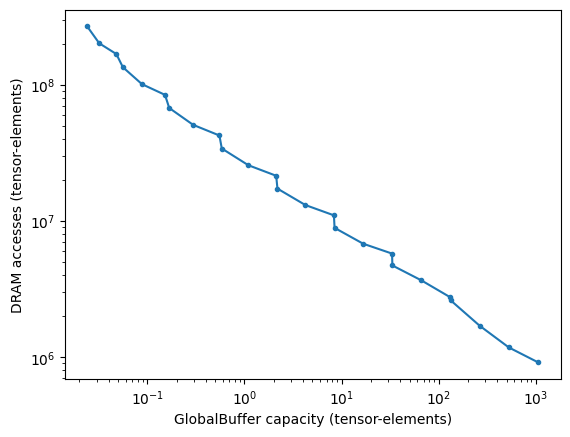

In [49]:
# Matrix multiplication from Section 1
spec = af.Spec.from_yaml(
    af.examples.arches.orojenesis,
    "workload/matmul.yaml",
    jinja_parse_data={"M": 1024, "N": 512, "K": 256}
)
spec.mapper.metrics = Metrics.ENERGY | Metrics.RESOURCE_USAGE
result = spec.map_workload_to_arch()
result.data.sort_values('reservation<SEP>GlobalBuffer<SEP>-1<SEP>right', inplace=True)
plt.plot(1e12*np.array(result.resource_usage()["GlobalBuffer"]), np.array(result.energy())/8, marker='.')
plt.xlabel("GlobalBuffer capacity (tensor-elements)")
plt.ylabel("DRAM accesses (tensor-elements)")
plt.xscale("log")
plt.yscale("log")

Please answer the following question.

In [50]:
# The minimum DRAM accesses are reached when all data fits in GLB
# Total data = M*K + K*N + M*N = 262144 + 131072 + 524288 = 917504 ~ 10^6
# Nearest power of 10 is 6
answer(
    "4.1.1",
    """
    At what GlobalBuffer capacity is minimum DRAM accesses
    reached?
    Answer with the nearest power of ten (e.g., if the
    GlobalBuffer capacity is 2.3e4, answer with 4.)
    """,
    required_type=int,
    answer= 6,
)

4.1.1: 
    At what GlobalBuffer capacity is minimum DRAM accesses
    reached?
    Answer with the nearest power of ten (e.g., if the
    GlobalBuffer capacity is 2.3e4, answer with 4.)
    
	6


The ski-slope curve is generated by exploring the full mapspace after removing any constraint or consideration for any metric other than accesses to the off-chip memory and the usage of on-chip memory capacity, a method first introduced by [Huang et al.](https://dl.acm.org/doi/10.1109/ISCA59077.2024.00021)
This method ensures that the theoretical minimum off-chip data movement is achieved (since nothing else is considered for optimization), and makes the mapspace exploration very fast.

On the other hand, the ski-slope bound should not be interpreted as the absolute last word on the size of your on-chip memory.
As we have seen in this lab, using parallelism may require larger on-chip memory to keep the larger tile shapes needed for parallelism.
Rather, you can use it in two ways:
- as a starting point to design your on-chip memory capacity (but remember that parallelism may make the actual required capacity much higher),
- to see the gap between the DRAM accesses you achieved and what is theoretically possible, which might help you identify inefficiencies.

Finally, we will show the ski-slope bound for the workload in Section 3, including the capacity and DRAM accesses achieved by the provided default architecture configuration.
Run the following cell.

Getting energy, latency, and leak power for components running :   0%|          | 0/2 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running EinsumY:   0%|          | 0/2 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running EinsumZ:   0%|          | 0/2 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running EinsumZ: 100%|██████████| 2/2 [00:00<00:00, 40.62it/s]

Generating jobs:   0%|          | 0/2 [00:00<?, ?it/s]

Generating pmapping templates for compute MAC Einsum EinsumY: 12it [00:00, 180.91it/s]
Generating pmapping templates for compute MAC Einsum EinsumZ: 12it [00:00, 184.52it/s]
Generating jobs:  50%|█████     | 1/2 [00:00<00:00,  8.53it/s]

Generating jobs: 100%|██████████| 2/2 [00:00<00:00, 16.88it/s]

Einsum EinsumY has 12 pmapping templates:
	0	[B in MainMemory] [A in MainMemory] T-m  T-ny  [A in GlobalBuffer] T-ny  [B in GlobalBuffer] T-m  [Y in GlobalBuffer] T-m  T-na  T-ny  MAC computes EinsumY
	1	[B in MainMemory] [A in MainMemory] T-m  T-ny  [A in GlobalBuffer] T-ny  [Y in GlobalBuffer] T-na  T-ny  [B in GlobalBuffer] T-m  MAC computes EinsumY
	2	[B in MainMemory] [A in MainMemory] T-m  T-ny  [B in GlobalBuffer] T-m  [A in GlobalBuffer] T-ny  [Y in GlobalBuffer] T-m  T-na  T-ny  MAC computes EinsumY
	3	[B in MainMemory] [A in MainMemory] T-m  T-ny  [B in GlobalBuffer] T-m  [Y in GlobalBuffer] T-m  T-na  [A in GlobalBuffer] T-ny  MAC computes EinsumY
	4	[B in MainMemory] [A in MainMemory] T-m  T-ny  [Y in GlobalBuffer] T-m  T-na  [A in GlobalBuffer] T-ny  [B in GlobalBuffer] T-m  MAC computes EinsumY
	5	[B in MainMemory] [A in MainMemory] T-m  T-ny  [Y in GlobalBuffer] T-na  T-ny  [B in GlobalBuffer] T-m  [A in GlobalBuffer] T-ny  MAC computes EinsumY
	6	[Y in MainMemory] [B in

Generating pmappings:   0%|          | 0/24 [00:00<?, ?it/s]

Generating pmappings:   4%|▍         | 1/24 [00:00<00:03,  6.31it/s]

Generating pmappings:  25%|██▌       | 6/24 [00:00<00:00, 26.89it/s]

Generating pmappings:  50%|█████     | 12/24 [00:00<00:00, 38.58it/s]

Generating pmappings:  75%|███████▌  | 18/24 [00:00<00:00, 44.80it/s]

Generating pmappings:  96%|█████████▌| 23/24 [00:00<00:00, 34.87it/s]

Generating pmappings: 100%|██████████| 24/24 [00:00<00:00, 31.61it/s]

Grouping pmappings for EinsumY:   0%|          | 0/7 [00:00<?, ?it/s]

Grouping pmappings for EinsumY:  71%|███████▏  | 5/7 [00:00<00:00, 45.73it/s]

Grouping pmappings for EinsumY: 100%|██████████| 7/7 [00:00<00:00, 27.63it/s]

Grouping pmappings for EinsumZ:   0%|          | 0/7 [00:00<?, ?it/s]

Grouping pmappings for EinsumZ: 100%|██████████| 7/7 [00:00<00:00, 66.08it/s]

Grouping pmappings for EinsumZ: 100%|██████████| 7/7 [00:00<00:00, 65.12it/s]

EinsumY: 2.88e04 total, 4.77e03 (1/6) valid, 6.24e03 (1/5) evaluated, 1.73e03 (1/17) Pareto-Optimal
EinsumZ: 2.88e04 total, 4.77e03 (1/6) valid, 6.24e03 (1/5) evaluated, 1.73e03 (1/17) Pareto-Optimal
Total: 5.76e04 total, 9.54e03 (1/6) valid, 1.25e04 (1/5) evaluated, 3.46e03 (1/17) Pareto-Optimal


Compressing pmappings:   0%|          | 0/2 [00:00<?, ?it/s]

Compressing pmappings: 100%|██████████| 2/2 [00:00<00:00, 31.07it/s]

Joining pmappings for EinsumY <--> EinsumZ (2/2):   0%|          | 0/11 [00:00<?, ?it/s]

Joining pmappings for EinsumY <--> EinsumZ (2/2): 100%|██████████| 11/11 [00:00<00:00, 172.65it/s]

Final consolidate:   0%|          | 0/11 [00:00<?, ?it/s]

Final consolidate: 100%|██████████| 11/11 [00:00<00:00, 387.52it/s]

Grouping pmappings:   0%|          | 0/1 [00:00<?, ?it/s]

Grouping pmappings: 100%|██████████| 1/1 [00:00<00:00, 48.16it/s]

Evaluating chosen mappings in detail:   0%|          | 0/40 [00:00<?, ?it/s]

Evaluating chosen mappings in detail:   2%|▎         | 1/40 [00:00<00:07,  5.41it/s]

Evaluating chosen mappings in detail:  15%|█▌        | 6/40 [00:00<00:01, 23.13it/s]

Evaluating chosen mappings in detail:  22%|██▎       | 9/40 [00:00<00:01, 25.09it/s]

Evaluating chosen mappings in detail:  38%|███▊      | 15/40 [00:00<00:00, 28.88it/s]

Evaluating chosen mappings in detail:  52%|█████▎    | 21/40 [00:00<00:00, 33.86it/s]

Evaluating chosen mappings in detail:  68%|██████▊   | 27/40 [00:01<00:00, 18.66it/s]

Evaluating chosen mappings in detail:  92%|█████████▎| 37/40 [00:01<00:00, 29.09it/s]

Evaluating chosen mappings in detail: 100%|██████████| 40/40 [00:01<00:00, 24.82it/s]

Getting energy, latency, and leak power for components running :   0%|          | 0/2 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running EinsumY:   0%|          | 0/2 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running EinsumZ:   0%|          | 0/2 [00:00<?, ?it/s]

Getting energy, latency, and leak power for components running EinsumZ: 100%|██████████| 2/2 [00:00<00:00, 35.23it/s]

Generating jobs:   0%|          | 0/2 [00:00<?, ?it/s]

Generating pmapping templates for compute MAC Einsum EinsumY: 22it [00:00, 227.03it/s]
Generating jobs:  50%|█████     | 1/2 [00:00<00:00,  7.36it/s]

Generating pmapping templates for compute MAC Einsum EinsumZ: 22it [00:00, 211.78it/s]


Generating jobs: 100%|██████████| 2/2 [00:00<00:00, 13.28it/s]

Einsum EinsumY has 22 pmapping templates:
	0	[B in DRAM] [A in DRAM] T-m  T-ny  [Y in L2] T-na  T-ny  S-Y-ny  S-X-na  [B in RF] T-m  MAC computes EinsumY
	1	[B in DRAM] [A in DRAM] T-m  T-ny  [Y in L2] T-m  T-na  S-Y-ny  S-X-na  [A in RF] T-ny  [B in RF] T-m  MAC computes EinsumY
	2	[B in DRAM] [A in DRAM] T-m  T-ny  [Y in L2] T-na  T-ny  S-Y-ny  S-X-na  [B in RF] T-m  [A in RF] T-ny  MAC computes EinsumY
	3	[B in DRAM] [A in DRAM] T-m  T-ny  [Y in L2] T-na  T-ny  S-Y-ny  S-X-na  [B in RF] T-m  [Y in RF] T-na  MAC computes EinsumY
	4	[B in DRAM] [A in DRAM] T-m  T-ny  [Y in L2] T-m  T-ny  S-Y-ny  S-X-na  [Y in RF] T-na  [B in RF] T-m  MAC computes EinsumY
	5	[B in DRAM] [A in DRAM] T-m  T-ny  [Y in L2] T-m  T-na  S-Y-ny  S-X-na  [A in RF] T-ny  [B in RF] T-m  [Y in RF] T-na  MAC computes EinsumY
	6	[B in DRAM] [A in DRAM] T-m  T-ny  [Y in L2] T-m  T-na  S-Y-ny  S-X-na  [A in RF] T-ny  [Y in RF] T-na  [B in RF] T-m  MAC computes EinsumY
	7	[B in DRAM] [A in DRAM] T-m  T-ny  [Y in L2] T-

Generating pmappings:   0%|          | 0/44 [00:00<?, ?it/s]

Generating pmappings:   2%|▏         | 1/44 [00:00<00:19,  2.16it/s]

Generating pmappings:   5%|▍         | 2/44 [00:00<00:15,  2.66it/s]

Generating pmappings:   7%|▋         | 3/44 [00:00<00:10,  3.89it/s]

Generating pmappings:  11%|█▏        | 5/44 [00:01<00:06,  6.11it/s]

Generating pmappings:  20%|██        | 9/44 [00:01<00:03, 11.60it/s]

Generating pmappings:  25%|██▌       | 11/44 [00:01<00:02, 12.13it/s]

Generating pmappings:  34%|███▍      | 15/44 [00:01<00:01, 17.59it/s]

Generating pmappings:  41%|████      | 18/44 [00:01<00:01, 16.32it/s]

Generating pmappings:  45%|████▌     | 20/44 [00:01<00:01, 15.71it/s]

Generating pmappings:  55%|█████▍    | 24/44 [00:01<00:00, 20.09it/s]

Generating pmappings:  61%|██████▏   | 27/44 [00:02<00:00, 18.73it/s]

Generating pmappings:  68%|██████▊   | 30/44 [00:02<00:00, 19.32it/s]

Generating pmappings:  80%|███████▉  | 35/44 [00:02<00:00, 25.56it/s]

Generating pmappings:  89%|████████▊ | 39/44 [00:02<00:00, 28.72it/s]

Generating pmappings:  98%|█████████▊| 43/44 [00:02<00:00, 26.05it/s]

Generating pmappings: 100%|██████████| 44/44 [00:02<00:00, 14.86it/s]

Grouping pmappings for EinsumY:   0%|          | 0/4 [00:00<?, ?it/s]

Grouping pmappings for EinsumY: 100%|██████████| 4/4 [00:00<00:00, 27.94it/s]

Grouping pmappings for EinsumY: 100%|██████████| 4/4 [00:00<00:00, 27.61it/s]

Grouping pmappings for EinsumZ:   0%|          | 0/4 [00:00<?, ?it/s]

Grouping pmappings for EinsumZ: 100%|██████████| 4/4 [00:00<00:00, 37.61it/s]

Grouping pmappings for EinsumZ: 100%|██████████| 4/4 [00:00<00:00, 37.19it/s]

EinsumY: 6.44e06 total, 888 (1/7.25e03) valid, 4.98e04 (1/129) evaluated, 320 (1/2.01e04) Pareto-Optimal
EinsumZ: 6.44e06 total, 3.52e03 (1/1.83e03) valid, 4.98e04 (1/129) evaluated, 231 (1/2.79e04) Pareto-Optimal
Total: 1.29e07 total, 4.41e03 (1/2.92e03) valid, 9.96e04 (1/129) evaluated, 551 (1/2.34e04) Pareto-Optimal


Compressing pmappings:   0%|          | 0/2 [00:00<?, ?it/s]

Compressing pmappings: 100%|██████████| 2/2 [00:00<00:00, 62.55it/s]

Joining pmappings for EinsumY <--> EinsumZ (2/2):   0%|          | 0/4 [00:00<?, ?it/s]

Joining pmappings for EinsumY <--> EinsumZ (2/2): 100%|██████████| 4/4 [00:00<00:00, 125.26it/s]

Final consolidate:   0%|          | 0/4 [00:00<?, ?it/s]

Final consolidate: 100%|██████████| 4/4 [00:00<00:00, 330.75it/s]

Grouping pmappings:   0%|          | 0/1 [00:00<?, ?it/s]

Grouping pmappings: 100%|██████████| 1/1 [00:00<00:00, 174.86it/s]

Evaluating chosen mappings in detail:   0%|          | 0/2 [00:00<?, ?it/s]

Evaluating chosen mappings in detail:  50%|█████     | 1/2 [00:00<00:00,  2.94it/s]

Evaluating chosen mappings in detail: 100%|██████████| 2/2 [00:00<00:00,  4.45it/s]

Evaluating chosen mappings in detail: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

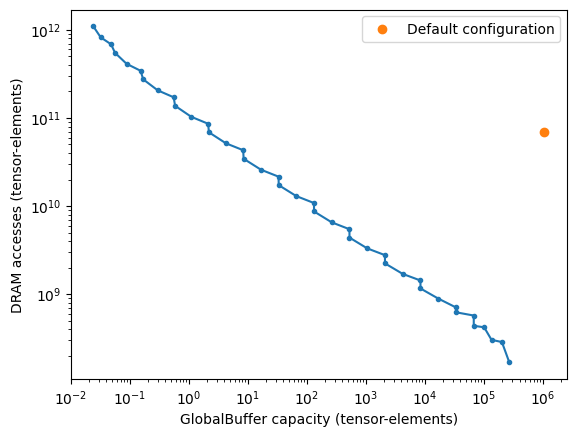

In [51]:
spec = af.Spec.from_yaml(
    af.examples.arches.orojenesis,
    "workload/matmul_matmul.yaml",
    jinja_parse_data=dict(
        M=M,
        NA=NA, 
        NY=NY,
        NZ=NZ,
    )
)
spec.mapper.metrics = Metrics.ENERGY | Metrics.RESOURCE_USAGE
result = spec.map_workload_to_arch()
result.data.sort_values('reservation<SEP>GlobalBuffer<SEP>-1<SEP>right', inplace=True)
plt.plot(1e12*np.array(result.resource_usage()["GlobalBuffer"]), np.array(result.energy())/8, marker='.')
plt.xlabel("GlobalBuffer capacity (tensor-elements)")
plt.ylabel("DRAM accesses (tensor-elements)")
plt.xscale("log")
plt.yscale("log")

memory_hierarchy = DEFAULT_CONFIGURATION["memory_hierarchy"]
array_x = DEFAULT_CONFIGURATION["array_x"]
array_y = DEFAULT_CONFIGURATION["array_y"]
rf_capacity = DEFAULT_CONFIGURATION["rf_capacity"]
spec = af.Spec.from_yaml(
    "arch/scaffold.yaml",
    "workload/matmul_matmul.yaml",
    jinja_parse_data=dict(
        M=M,
        NA=NA, 
        NY=NY,
        NZ=NZ,
        DRAM_BW=DRAM_BW,
        memory_hierarchy=memory_hierarchy,
        array_x=array_x,
        array_y=array_y,
        rf_capacity=rf_capacity,
    )
)
spec.mapper.metrics = Metrics.LATENCY | Metrics.ENERGY
area = spec.calculate_component_area_energy_latency_leak().arch.total_area
mappings = spec.map_workload_to_arch()
mappings = mappings[min_edp_filter(mappings.data)]

actions = mappings.actions()
DRAM_accesses = (actions[('DRAM', 'read')] + actions[('DRAM', 'write')])/8
capacity = DEFAULT_CONFIGURATION["memory_hierarchy"][0]["capacity"]

plt.scatter(capacity, DRAM_accesses, color="tab:orange", label="Default configuration")
plt.legend()

Please answer the following question.

In [52]:
# The default config (8x8 array, small RF) does not reach the ski-slope bound
# due to limited parallelism and suboptimal mapping
answer(
    "4.1.2",
    """
    True/False: does the default architecture configuration reach
    the ski slope bound?
    """,
    required_type=bool,
    answer= False,
)

4.1.2: 
    True/False: does the default architecture configuration reach
    the ski slope bound?
    
	False


## Concluding Lab 3

You are finished with lab 3! Please follow the instructions in the README to submit your answers.